<a href="https://colab.research.google.com/github/ILYAGRISH/ILYAGRISH/blob/main/L09_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a href="https://msu.ai/"><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.4/msu_ai.png" width="1024"></a></center>

<font size="6">Рекуррентные нейронные сети (RNN)</font>

#  Временные ряды

В предыдущих лекциях мы работали с данными **фиксированной длины**, у которых не было **временной связности**.

Если это **табличные данные**, то мы заранее знаем длину вектор-описания объекта, а также размер выхода модели: одно это число или вектор.

Верно это и про **изображения** — обычно нейронная сеть учится на изображениях определенного разрешения. Мы можем сделать нейросеть, которая способна работать с изображением почти любого разрешения, но добиваемся этого за счет вставки слоев **global pooling**, которые  приводят признаковое описание, полученное сверточной частью нейросети, к фиксированному размеру.

Однако далеко **не все данные обладают фиксированным размером**. Типичным представителем таких данных являются **временные ряды**.

Кроме того, мы рассчитываем, что значения ряда в прошлом содержат важную информацию о поведении ряда в будущем с сохранением тенденции на определённом интервале (что отличается от классических ML-задач, предполагающих независимость наблюдений).

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/ts_intro.png" width="800"></center>

Давайте научимся с ними работать, но для начала разберём основные понятия.



## Компоненты временных рядов


Временной ряд представляет собой последовательность вещественных значений $t \in R^{N+1}$, измеренных через одинаковые промежутки времени $\Delta t$ до момента времени $T$:

$$\large y_i = y(t_i)$$

**Составляющие временных рядов.**

$$\large y(t_i) = f(T,S,C,I, t_i)$$

**Тренд** $T(t)$ — компонента, описывающая долгосрочное изменение уровня ряда.

**Сезонность** $S(t)$ — компонента, описывающая периодические изменения уровня ряда.

**Цикличность** $C(t)$ — компонента, описывающая изменения уровня ряда с переменным периодом.

**Шум (irregular fluctuations)** $I(t)$ — непрогнозируемая случайная компонента, описывающая нерегулярные изменения в данных, необъяснимые другими компонентами.

$$\large y_i = T_i + S_i + C_i + I_i$$

Разница между циклической и сезонной компонентой состоит в том, что последняя имеет регулярную (сезонную) периодичность, тогда как циклические факторы обычно имеют более длительный эффект, который к тому же меняется от цикла к циклу.

Здесь нет единого мнения: другие исследователи могут выделить и иные компоненты, также компоненты могут быть не только аддитивными, но и мультипликативными:

$$\large y_i = T_i * S_i * C_i * I_i$$

От которых, логарифмируя, мы вновь можем прийти к аддитивной модели:

$$\large \ln {y_i} = \ln T_i + \ln S_i + \ln C_i + \ln I_i$$

$$\large \hat {y_i} = \hat T_i + \hat S_i + \hat C_i + \hat I_i$$

В данной лекции мы будем опираться для простоты на аддитивную модель, однако учитывайте, что бывают и более сложные, смешанные варианты.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/ts_components.png" width="800"></center>

⛔ Если ваш **ряд не равномерый**, т.е. интервалы между наблюдениями не равны, необходимо сделать ряд равномерным. Например, заполнить пропуски интерполяцией.

Если это сделать нельзя, добро пожаловать в увлекательный мир [анализа случайных процессов 📚[book]](https://www.ssau.ru/files/resources/sotrudniki/prohorov/9_pasp.pdf)!


## Задачи анализа временных рядов

В анализе временных рядов можно выделить следующие задачи:

* Идентификация (установление свойств)
* Прогнозирование
* Поиск аномалий
* Классификация
* Кластеризация


Рассмотрим подробнее задачу прогнозирования.

**Задача прогнозирования**: найти функцию $\large f_T$:

$$\large y_{T+h} ≈ f_T(y_T, \dots ,y_1, h),$$

где $h \in \{1,2,\dots, H\}$, $H$ — горизонт прогнозирования.

Помимо самих значений, важно также оценивать **предсказательный интервал**, в котором предсказываемая величина окажется с вероятностью, не менее заданной.

**Стационарность временных рядов**

Для построения стабильной модели предсказания будет **полезно иметь ширину распределения целевого значения не зависящей от времени**. Для этого необходимо добиться стационарности ряда.

Временной ряд $y_t$ называется **строго стационарным**, если его распределение не зависит от времени, т.е. смещение во времени не меняет его статистических свойств.

Ряд $\large y_t$ строго стационарен, если для любого набора временных точек $\large t_1, t_2, ..., t_k$ и для любого сдвига $h$ совместное распределение $\large y_{t_1}, y_{t_2}, ..., y_{t_k}$ совпадает с $\large y_{t_1+h}, y_{t_2+h}, ..., y_{t_k+h}$, то есть **вся совокупность распределений** остаётся неизменной при любом временном сдвиге.

На практике строгое определение стационарности в машинном обучении практически не применяется, для большинства задач достаточно определения стационарности временного ряда в **широком смысле** (**слабой стационарности**).

Временной ряд $y_t$ называется стационарным в **широком смысле**, если выполняются 3 условия:

1. Среднее значение постоянное и не зависит от времени.
2. Дисперсия (разброс значений) постоянная и не зависит от времени.
3. Автокорреляция (связь текущего и прошлых значений) не зависит от времени, а зависит только от сдвига $h$.

Наличие тренда, сезонности, цикличности приводит к нестационарности.

Давайте посмотрим на примерах.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/ts_stationarity.png" width="1000"></center>


Помимо того, что ряд может считаться стационарным или нестационарным, встречаются и комбинированные ряды (на определенных периодах стационарные, на других — нет). Общий совет — [сегментируйте 🛠️[doc]](https://centre-borelli.github.io/ruptures-docs/).

Чтобы не анализировать стационарность визуально, существуют различные тесты:
1. Расширенный тест Дикки-Фуллера (ADF)
2. Тест Филлипса-Перрона
3. Тест **Квятковского-Филлипса-Шмидта-Шина (KPSS)**

И множество других.

Как правило, применяют несколько тестов разом, чтобы удостовериться в результате. Одним из самых популярных является KPSS.

Тест проверяет гипотезу о том, что ряд стационарен, против альтернативы, что ряд не стационарен. Обычно критерии устроены наоборот.

<div align="center">
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
<font size="2" face="Times New Romans" >


</style>
</head>
<body>

<table >
<tr>

<td>



</td>
<td>

$\large \text{KPSS}$

</td>
<td>

$\large \text{ADF}$

</td>
<tr>

<td>

ряд:
    
</td>
<td>

$\large y = y_1, \dots, y_T$

</td>  
<td>

$\large y = y_1, \dots, y_T$

</td>


</tr>
<td>

нулевая гипотеза:

</td>
<td>

$\large H_0$: ряд $\large y$ **стационарен**

</td>  

<td>

$\large H_0$: ряд $\large y$ **нестационарен**

</td>

  </tr>
  <tr>
    <td>

альтернатива:

</td>
<td>

$\large H_1$: ряд $\large y$ описывается моделью вида $\large y_t = αy_{t-1}$
    
</td>  

<td>

$\large H_1$: ряд стационарен
    
</td>

  </tr>


  <tr>
    <td>
    
p-value < 0.05:
    
</td>

<td>
    
$\large H_0$ отвергается, ряд нестационарен.
    
</td>  

<td>
    
$\large H_0$ отвергается, ряд стационарен.
    
</td>

</tr>







**Пример**

Возьмем датасет [Air Passengers 🛠️[doc]](https://www.kaggle.com/rakannimer/air-passengers), который содержит данные о количестве пассажиров за каждый месяц.


In [ ]:
import pandas as pd

dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/airline-passengers.csv"
)
dataset.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


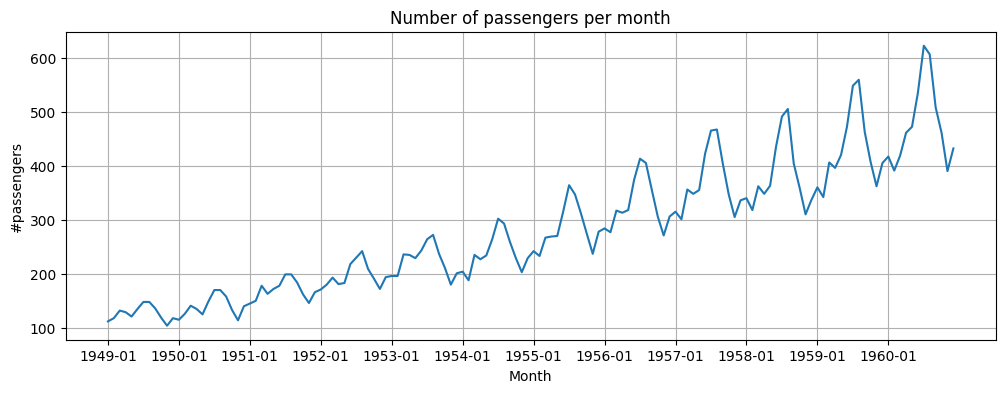

In [ ]:
import matplotlib.pyplot as plt

training_data = dataset["Passengers"].values  # transform dataframe to numpy.array
# Plotting
plt.figure(figsize=(12, 4))
plt.plot(training_data, label="Airline Passangers Data")
plt.title("Number of passengers per month")
plt.ylabel("#passengers")
plt.xlabel("Month")
labels_to_display = [i for i in range(training_data.shape[0]) if i % 12 == 0]
plt.xticks(labels_to_display, dataset["Month"][labels_to_display])
plt.grid()
plt.show()

**Сделаем стационарнее**

В сезонной компоненте размах явно растёт со временем. Причина в мультипликативной природе ряда. Чтобы от такого избавиться, можно применить уже известное вам преобразование Бокса-Кокса или же обыкновенное логарифмирование.

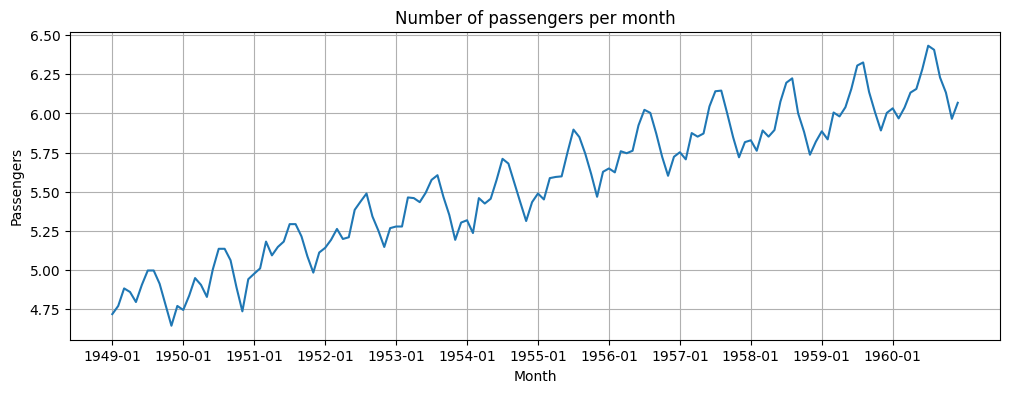

In [ ]:
import numpy as np

training_data = np.log(dataset["Passengers"].values)

plt.figure(figsize=(12, 4))
plt.plot(training_data, label="Airline Passangers Data")
plt.title("Number of passengers per month")
plt.ylabel("Passengers")
plt.xlabel("Month")
labels_to_display = [i for i in range(training_data.shape[0]) if i % 12 == 0]
plt.xticks(labels_to_display, dataset["Month"][labels_to_display])
plt.grid()
plt.show()

Мы можем видеть четкую сезонность и тенденцию к увеличению значений. Зная природу данных, мы сразу можем сказать, что сезонность имеет период 12. Объединим все наши операции с помощью функции `seasonal_decompose`.

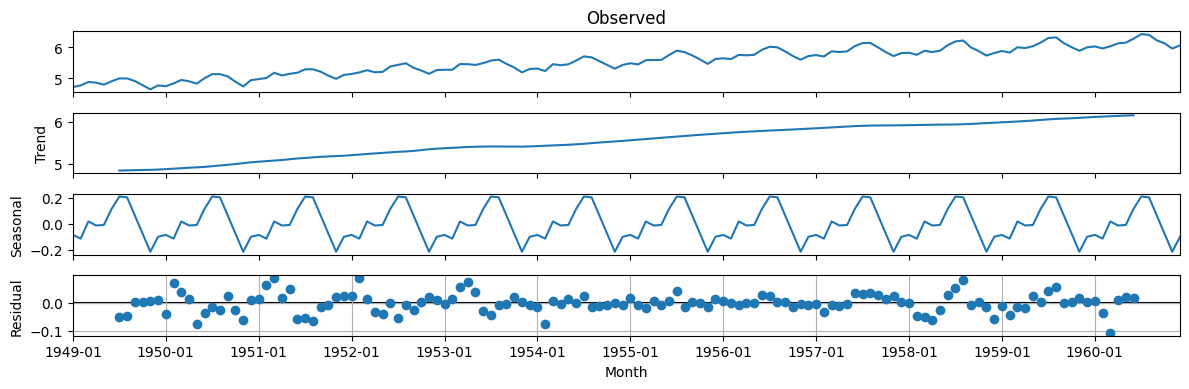

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(training_data, model="additive", period=12)

fig = result.plot()
fig.set_size_inches((12, 4))
plt.xlabel("Month")
labels_to_display = [i for i in range(training_data.shape[0]) if i % 12 == 0]
plt.xticks(labels_to_display, dataset["Month"][labels_to_display])
plt.grid()
fig.tight_layout()
plt.show()

В тесте KPSS есть параметр `regression`, который позволяет менять формулировку нулевой гипотезы:
* `regression="c"` — нулевая гипотеза формулируется как "ряд стационарен относительно константы"
* `regression="ct"` — нулевая гипотеза формулируется как "ряд стационарен относительно линейного тренда".

Заметим, что во втором случае, если по результатам теста у нас будут основания не отвергать нулевую гипотезу, то это значит, что в ряде есть явный линейный тренд и он не является стационарным в широком смысле.

In [ ]:
import warnings
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.simplefilter("ignore", InterpolationWarning)

test = kpss(result.seasonal, regression="c")

print("kpss:", test[0])
print("p-value:", test[1])

if test[1] > 0.05:
    print("The time series is stationary around a constant")
else:
    print("The time series is not stationary around a constant")

kpss: 0.009541815606432172
p-value: 0.1
The time series is stationary around a constant


Значние `p-value` подтверждает гипотезу о том, что ряд стационарен.

Проведем расширенный тест Дики-Фуллера на сезонной компоненте.

In [ ]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(result.seasonal)

print("adf: ", test[0])
print("p-value: ", test[1])
# print("Critical values: ", test[4])

if test[0] > test[4]["5%"]:
    print("The time series is not stationary")
else:
    print("The time series is stationary")

adf:  -4279375526324772.5
p-value:  0.0
The time series is stationary


Оба теста говорят о стационарности сезонной компоненты ряда.

Также мы можем отметить, что трендовая компонента не вполне является прямой линией. Дело в том, что на самом деле в неё входит циклическая составляющая. Попробуем их разделить через аппроксимацию прямой.

In [ ]:
trend = result.trend[~np.isnan(result.trend)]

In [ ]:
x = np.arange(len(trend))
y = trend
k, b = np.polyfit(x, y, 1)  # y = k*x+b

In [ ]:
real_trend = np.arange(len(trend)) * k + [b] * len(trend)
cycle = trend - real_trend

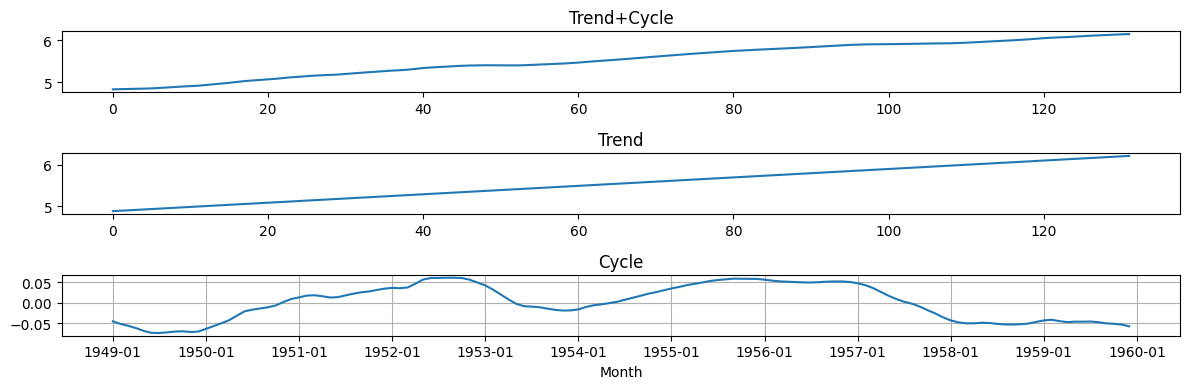

In [ ]:
fig, ax = plt.subplots(3, 1)

fig.set_size_inches((12, 4))
plt.xlabel("Month")
labels_to_display = [i for i in range(training_data.shape[0]) if i % 12 == 0]
plt.xticks(labels_to_display, dataset["Month"][labels_to_display])
plt.grid()
fig.tight_layout()

ax[0].plot(trend)
ax[0].set_title("Trend+Cycle")
ax[1].plot(real_trend)
ax[1].set_title("Trend")
ax[2].plot(cycle)
ax[2].set_title("Cycle")
fig.tight_layout()
plt.show()

Выделение циклов — дело неблагодарное, в редких работах вы это встретите. Для автоматического поиска цикла может быть полезен [фильтр Годрика-Прескотта 🛠️[doc]](https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html).

## Особенности валидации при анализе временных рядов



При обучении моделей следует обращать внимание на разбиение временного ряда на **train-val-test**.

Как и в иных областях, при работе с временными рядами полезно оценить качество модели с помощью кросс-валидации. Наличие строгой временной зависимости не позволяет нам случайно разделять ряд на подвыборки.

Отличным вариантом будет обучать модель, сдвигаясь вправо по временной оси, каждый раз добавляя отрезок новых данных в качестве валидации и обучаясь на всех данных слева.


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/ts_crossval.png" width="700"></center>

<center><em>Source: <a href="https://forecastegy.com/posts/time-series-cross-validation-python/">How To Do Time Series Cross-Validation In Python</a></em></center>

Это не единственный способ разделения ряда. Так, на самом деле, пытливый слушатель может отметить, что качество модели на первом шаге вероятно будет ниже, чем на последующих, просто потому, что модель на последующих шагах обучена на большем количестве данных. Поэтому можно идти вдоль ряда окном постоянного размера.

Другие варианты разбиения временного ряда:

[[blog] ✏️ How To Do Time Series Cross-Validation In Python](https://forecastegy.com/posts/time-series-cross-validation-python/)

Для этих целей воспользуемся функцией `TimeSeriesSplit` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) библиотеки Sklearn.

Стоит отметить, что можно задать `gap` — отступ с правого края,  максимальный размер обучающей выборки на каждом разбиении `max_train_size`, размер данных для теста `test_size`.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

x = np.random.randn(17, 2)

tscv = TimeSeriesSplit(gap=3, n_splits=3, test_size=2)
print(tscv)

for i, (train_index, test_index) in enumerate(tscv.split(x)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

TimeSeriesSplit(gap=3, max_train_size=None, n_splits=3, test_size=2)
Fold 0:
  Train: index=[0 1 2 3 4 5 6 7]
  Test:  index=[11 12]
Fold 1:
  Train: index=[0 1 2 3 4 5 6 7 8 9]
  Test:  index=[13 14]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11]
  Test:  index=[15 16]


**Rolling forecasting**

Мы можем выделить два режима предсказания модели. Рассмотрим пример предсказания погоды:
* на завтра
* вперёд на две следующих недели

В первом случае имеется самая близкая информация на горизонт прогнозирования и ошибка будет минимальна.

Во втором случае предсказание с каждым днём будет менее точным. Скажем, предсказание модели на второй день будет основываться не только на истинных данных, но и на предсказанных.

Грубо говоря, во втором случае мы опускаем модель в "свободное плавание".

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/ts_forecasting.png" width="700"></center>

In [ ]:
tscv = TimeSeriesSplit(gap=3, n_splits=5, max_train_size=5, test_size=2)
print(tscv)

for i, (train_index, test_index) in enumerate(tscv.split(x)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

TimeSeriesSplit(gap=3, max_train_size=5, n_splits=5, test_size=2)
Fold 0:
  Train: index=[0 1 2 3]
  Test:  index=[7 8]
Fold 1:
  Train: index=[1 2 3 4 5]
  Test:  index=[ 9 10]
Fold 2:
  Train: index=[3 4 5 6 7]
  Test:  index=[11 12]
Fold 3:
  Train: index=[5 6 7 8 9]
  Test:  index=[13 14]
Fold 4:
  Train: index=[ 7  8  9 10 11]
  Test:  index=[15 16]


Если вы идеально научились смотреть в завтрашний день, то проблем в том, чтобы сделать это несколько раз подряд, нет. Но чтобы проверить, насколько хорошо, нужно это проверить, скажем, на тесте.

❗Может дать заметный эффект дообучение модели на всех данных перед предсказанием в неизвестность.

Впрочем, обучение на всех исторических данных не всегда разумно. Если ряд очевидно не будет повторять самые старые участки ряда, стоит их вовсе удалить.

И использовать метод скользящего окна.

# Линейные модели временных рядов

**Авторегрессионная модель** (Autoregression method (AR))

Линейная модель, в которой прогнозируемая величина представляет линейную комбинацию **$\large p$** предыдущих значений.

$$\large y_t = α + ϕ_{1}y_{t-1}+ϕ_{2}y_{t-2}+...+ϕ_{p}y_{t-p}+ ϵ_t,$$

где $y_t$ — **стационарный ряд**, $ϵ_t$ — гауссов шум со средним $0$ и дисперсией $\sigma^2_ϵ$.

**Метод скользящего среднего** (Moving average method (MA))

Линейная модель, в которой прогнозируемая величина представляет линейную комбинацию  $\large q$  предыдущих значений остатков от AR модели ряда:

$$\large y_t = α + ϵ_t + \theta_{1}ϵ_{t-1}+\theta_{2}ϵ_{t-2}+...+\theta_{q}ϵ_{t-q},$$

где $y_t$ — **стационарный ряд**, $ϵ_t$ — остатки от AR-модели ряда.

**ARMA**

Теорема Вольда: любой **стационарный** ряд может быть описан моделью **ARMA(p,q)** с любой заданной точностью.

$$\large y_t = α + ϵ_t + \sum_{i=1}^p ϕ_{i}y_{t-i} + \sum_{j=1}^q\theta_{j}ϵ_{t-j} $$

Модель предполагает, что временной ряд содержит две составляющие: авторегресионную и скользящее среднее, которые в модели обозначены $p$ и $q$:

* $p$ — порядок авторегрессии. Позволяет ответить на вопрос, будет ли очередной элемент ряда близок к значению $y$, если к нему были близки $p$ предыдущих значений.
* $q$ — порядок скользящего среднего. Позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.

**ARIMA**

Если ряд **после взятия $d$ последовательных разностей** сводится к стационарному, то для для прогнозирования можно применить комбинированную модель авторегрессии и скользящего среднего, обозначаемую как **ARIMA(p,d,q)**:

$$ \large (Δ^dy_t) = \sum ^p _{i=1} ϕ_t(Δ^dy_{t-i}) + ϵ_t + \sum ^q _{j=1} \theta_j(Δ^d ϵ_{t-j}) $$

Модель предполагает, что временной ряд содержит три составляющие: авторегресионную, скользящее среднее и **интегрированную**, которые в модели обозначены $p, d$ и $q$. Т.е. добавилось:

* $d$ — порядок интегрирования. Показывает, насколько элемент ряда близок по значению к $d$  предыдущим значениям, если разность между ними минимальна.

**SARMA** (Seasonable ARMA)

Если взять модель **ARMA(p,q)** и добавить к ней $P$ авторегрессионных компонент:

$$\large + \sum_{k=1}^{PS}ϕ_{k}y_{t-k} $$

и $Q$ компонет скользящего среднего:

$$\large +  \sum_{l=1}^{QS}\theta_{l}ϵ_{t-l},$$

то получим $\text{SARMA}(p,q) × (P,Q)$.







**SARIMA** (Seasonable ARIMA)

Модель $\text{SARIMA}(p,d,q) \times (P,D,Q)$ — модель $\text{SARMA}(p,q) \times (P,Q)$ для ряда, к которому $d$ раз применили обычное дифференцирование и $D$ раз — сезонное.

На самом деле именно эту модель обычно называют $\text{ARIMA}$.

**Разберемся с тем, откуда брать параметры для $\text{ARIMA}$.**

Существует отдельная теория о том, как выбирать оптимальные параметры модели, однако мы воспользуемся автоматическим подбором. Нам понадобится библиотека [StatsForecast 🛠️[doc]](https://nixtlaverse.nixtla.io/statsforecast/index.html):

In [ ]:
!pip install -q statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.7 MB/s eta 0:00:00


Загрузим датасет и преобразуем данные в совместимый с библиотекой формат.

In [ ]:
import pandas as pd

dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/airline-passengers.csv"
)

dataset["Month"] = pd.to_datetime(dataset["Month"])
dataset = dataset.rename(
    columns={"Month": "ds", "Passengers": "y"}
)  # rename columns to match StatsForecast format
dataset["unique_id"] = "airline"  # add "unique_id" column (required for StatsForecast)

# train/test split
train_size = int(len(dataset) * 0.9)
train_data, test_data = dataset.iloc[:train_size], dataset.iloc[train_size:]

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA


# Create the forecasting model
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)], freq="ME", n_jobs=-1  # Monthly end frequency
)

# Train the model and forecast the next 30 time steps
sf.fit(train_data)
forecast_df = sf.predict(30)

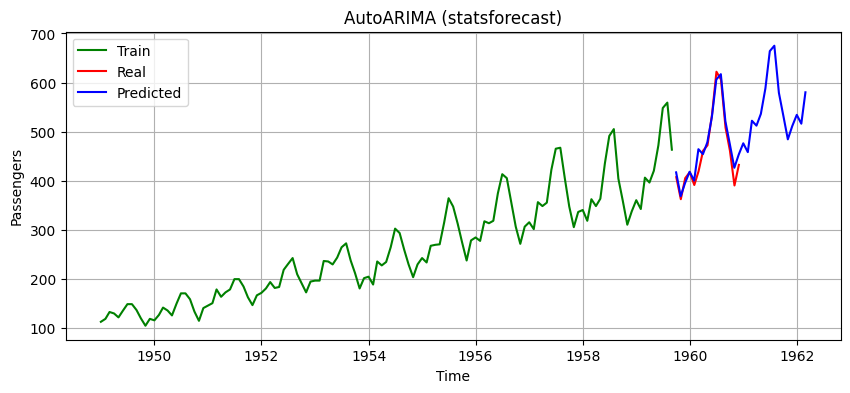

In [ ]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(10, 4))
plt.plot(train_data["ds"], train_data["y"], color="green", label="Train")
plt.plot(test_data["ds"], test_data["y"], color="red", label="Real")
plt.plot(forecast_df["ds"], forecast_df["AutoARIMA"], color="blue", label="Predicted")

plt.title("AutoARIMA (statsforecast)")
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Extract true and predicted values
y_true = test_data["y"].values
y_pred = forecast_df["AutoARIMA"].values[: len(y_true)]

# Calculate error metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MSE:  {mse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE:  328.78
MAE:  13.99
RMSE: 18.13


Если бы мы подбирали параметры вручную, получилось бы примерно то же самое по метрикам, но времени ушло бы больше.

📌 ARIMA-модели широко применяют не просто для решения задачи предсказания временных рядов, но скорее как экстракторы признаков. Обученная на отрезок временного ряда не фиксированной длины ARIMA позволяет получить конечного размера вектор признаков, состоящий из весов при компонентах, при помощи которого можно решать задачи известными из предыдущих лекций методами.

[[blog] ✏️ Обсуждение на Machinelearning Mastery](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

[[blog] ✏️ Forecasting Time Series with Auto-Arima](https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/)

# Нелинейные модели временных рядов

Для обработки остатков (полученных после удаления тренда и прочих компонет), имеющих сложную нелинейную структуру, имеет смысл использовать более мощные, нелинейные модели.



<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/decomposition_series_data.png" width="600"></center>

<center><em>Source: <a href="https://www.researchgate.net/publication/377532793_Improving_long-term_multivariate_time_series_forecasting_with_a_seasonal-trend_decomposition-based_2-dimensional_temporal_convolution_dense_network">Research Gate</a></em></center>



В качестве таких нелинейных моделей могут использоваться **рекуррентные нейронные сети (recurrent neural networks, RNN)**. Они применяются в широком перечне задач: от **распознавания речи** до **генерации подписей** к изображениям.

Эти задачи объединяет необходимость работы с контекстом и извлечения информации, сформированной при обработке одной части данных, для обработки других частей.

С моделями рекуррентных нейронных сетей конкурируют модели, основанные на архитектуре Transformer (подробнее с которыми мы познакомимся в соответствующей лекции).

Хотя сейчас трансформеры держат первенство во многих областях, **рекуррентные сети лучше** подходят для **обработки временных рядов**.

Кроме того, для обучения трансформеров в силу их размера требуется несоизмеримо большее количество данных, нежели для RNN (ровно как и вычислительных ресурсов как для обучения, так и для инференса).



## Рекуррентный слой в нейронных сетях

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/rnn_linear.png" width="600"></center>

<div align="center">
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
<font size="2" face="Times New Romans" >


</style>
</head>
<body>

<table >
<tr>


<td>

$$\text{nn.Linear(in_features=3, out_features=2)}$$

</td>
<td>

$$\text{nn.RNN(input_size=3, hidden_size=2)}$$

</td>
<tr>


<td>

$$\large h = f_{\text{act}}(W_{xh}x)$$

</td>  
<td>

$$\large h_t = f_{\text{act}}(W_{hh}h_{t-1} + W_{xh}x_t)$$

</td>


</tr>

<td>

$$\large y = f_{\text{act}}(W_{hy}h)$$

</td>  

<td>

$$\large y_t = f_{\text{act}}(W_{hy}h_t)$$

</td>

</tr>


**Основная идея RNN-слоя**: подавать на вход слоя не только входные значения, но также и выход этого же слоя в предыдущий такт времени.

1) Вход слоя в текущий такт времени $\large x_t$ пропускается через свою матрицу линейного преобразования $\large W_{xh}$.

2) Выходы слоя с предыдущего такта времени $\large h_{t-1}$ пропускаются через свою матрицу линейного преобразования $\large W_{hh}$.

3) Значения складываются и пропускаются через функцию активации, формируя текущее скрытое состояние $\large h_t$. **В качестве функции активации рекуррентого слоя чаще всего используется гиперболический тангенс.**

Дополнительно скрытое состояние рекуррентного слоя может пропускаться **через обычный линейный слой** для формирования выходного значения $\large y_t$.

Обычно $\large h_0$ инициализируется нулями.


Вычисления в рекуррентной нейронной сети можно "развернуть во времени":

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/linear_to_rnn.png" width="1000"></center>

**Вектор $\large h_t$ содержит накопленный при просмотре предыдущих $\large t$ элементов последовательности контекст.**

Схему выше для компактности можно представить следующим образом, скомпоновав вектора $\large x_t$, $\large h_t$ и $\large y_t$.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/rnn_basic_block.png" width="1000"></center>


Рассмотрим работу рекуррентной нейронной сети при обработке последовательности:
1. На вход поступает некоторая последовательность $\large x = \{x_1,...x_t,...,x_T\}$, где $\large x_t$ — вектор фиксированной размерности. В ряде случаев этот вектор имеет размерность $1$.

2. Для каждого поступившего $\large x_t$ формируем скрытое состояние $\large h_t$, которое фактически является линейным преобразованием от предыдущего состояния $\large h_{t-1}$ и текущего элемента последовательности $\large x_t$, к которому применяется нелинейная функция активации:
$$\large h_t = f_{\text{act}}(W_{hh}h_{t-1} + W_{xh}x_t),$$
где $\large W_{hh}$ и $\large W_{xh}$  — это матрицы обучаемых параметров (веса). Также может добавляться вектор смещений (bias).

3. На основании рассчитанного скрытого состояния, учитывающего предыдущие значения  $\large x_t$, формируется выходная последовательность $\large y = \{y_1,...y_t,...,y_T\}$. Для формирования предсказания $\large y_t$ в текущий момент времени в модель добавляется обычный линейный слой, принимающий на вход текущее скрытое состояние $\large h_t$.

Обратим внимание, что рекуррентная формула для расчета скрытого состояния

$$\large h_t = f_{\text{act}}(W_{hh}h_{t-1} + W_{xh}x_t)$$

может быть представлена в виде $$\large h_t = f_{\text{act}}(W\ [h_{t-1},x_t]),$$

где $\large [h_{t-1},x_t]$ — конкатенация векторов $\large h_{t-1}$ и $\large x_t$, а $\large W$ — соответственно конкатенация матриц $\large W_{hh}$ и $\large W_{xh}$.

## RNN слой в PyTorch

В PyTorch есть слой — `torch.nn.RNN` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), который реализует логику, описанную выше.

Также есть сущность `torch.nn.RNNCell` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html), которая реализует вычисления на одном такте времени.

Слой `nn.RNN` фактически является оберткой, которая вызывает `nn.RNNCell` в цикле по длине входной последовательности.

Параметры слоя `nn.RNN`:

* **`input_size`** — размерность $\large x_t$, целое число.

* **`hidden_size`** — размерность $\large h_t$, целое число. Фактически это количество нейронов в рекуррентном слое.


Техническая особенность рекуррентных слоев в PyTorch: по умолчанию ожидаемые размерности входа такие:

**`[длина последовательности, размер батча, размерность входа]`**

Однако если при создании слоя указать `batch_first=True`, то можно подавать входные значения в более привычном формате, когда размер батча стоит на первом месте:

**`[размер батча, длина последовательности, размерность входа]`**



In [ ]:
from IPython.display import clear_output

!pip install -q lightning==2.5.0
clear_output()

In [ ]:
import torch

torch.manual_seed(42)

rnn = torch.nn.RNN(input_size=3, hidden_size=2, batch_first=True)

dummy_batched_seq = torch.randn((16, 57, 3))  # batch_size, seq_len, input_size
out, h = rnn(dummy_batched_seq)

print("Input shape:".ljust(20), f"{dummy_batched_seq.shape}")
print("Out shape:".ljust(20), f"{out.shape}")
print("Last hidden state shape:".ljust(20), f"{h.shape}")

Input shape:         torch.Size([16, 57, 3])
Out shape:           torch.Size([16, 57, 2])
Last hidden state shape: torch.Size([1, 16, 2])


При вызове слой возвращает два объекта:
* `out` — последовательность скрытых состояний,
* `h` — скрытое состояние на последнем такте.

Мы указали `batch_first=True`, при этом `out` сохранил последовательность размерностей как у входа, а вот у `h` размерность батча встала на второе место.

In [ ]:
h_batch_first = h.permute(1, 0, 2)

print(f"h is last out: {(h_batch_first == out[:, -1:, :]).all().item()}")

h is last out: True


### Многослойные RNN

RNN-блоки можно объединять в слои, накладывая их друг на друга. Для этой операции в `torch.nn.RNN` есть аргумент `num_layers`, с помощью которого можно указать количество слоёв.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/rnn_multiple_layers.png" width="500"></center>

In [ ]:
dummy_input = torch.randn((16, 6, 3))  # batch_size, seq_len, input_size
rnn = torch.nn.RNN(input_size=3, hidden_size=2, num_layers=2, batch_first=True)

out, h = rnn(dummy_input)

print()
print("Out:\n", out.shape)  # Hidden states for all elements from top layer
print("h:\n", h.shape)  # Hidden states for last element for all layers


Out:
 torch.Size([16, 6, 2])
h:
 torch.Size([2, 16, 2])


## Пример прогнозирования временного ряда с помощью RNN

Рекуррентная сеть может выдавать некий ответ на каждом шаге, однако мы можем построить работу вот в такой логике:

🟢 Использовать только последний `hidden` для предсказания одного значения. Этот режим работы, который нам потребуется для обучения рекуррентной нейронной сети для прогнозирования временного ряда, называется **many-to-one**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/many_to_one.png" width="300"></center>

Загрузим датасет с информацией об объеме ежемесячных авиаперевозок с 1949 по 1960 год. Столбец с датами сразу приведем к формату `datetime` [🛠️[doc]](https://pandas.pydata.org/docs/user_guide/timeseries.html) для удобства.


In [ ]:
import pandas as pd

dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/airline-passengers.csv"
)
dataset.Month = pd.to_datetime(dataset.Month)
dataset.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


Выведем временной ряд:

In [ ]:
import matplotlib.pyplot as plt


def simple_display(data, xticks, label=None):
    plt.figure(figsize=(12, 4))
    plt.plot(xticks, data, label=label)
    plt.legend()
    plt.grid()
    plt.show()

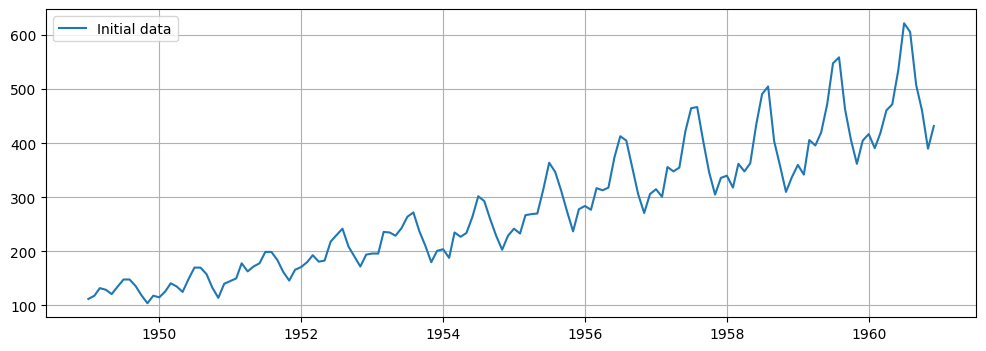

In [ ]:
data = dataset["Passengers"]
simple_display(data=data, xticks=dataset["Month"], label="Initial data")

Наблюдаем, что в данных явно присутствуют тренд, сезонность, а также гетероскедастичность (нестационарность по дисперсии). Сделать ряд гомоскедастичным можно, применив к нему логарифмирование.

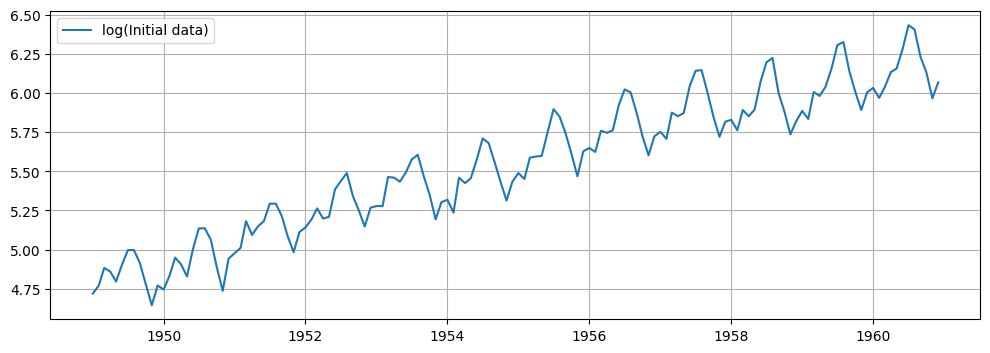

In [ ]:
import numpy as np

data_log = np.log(data)
simple_display(data=data_log, xticks=dataset["Month"], label="log(Initial data)")

### Разбиение на train-val-test

Разделим данные на:
* обучающие (январь 1949 &ndash; декабрь 1955),
* валидационные (январь 1956 &ndash; декабрь 1958),
* тестовые (январь 1959 &ndash; декабрь 1960).


In [ ]:
import datetime

train_start = datetime.datetime(1949, 1, 1)
train_end = datetime.datetime(1955, 12, 1)

val_start = datetime.datetime(1956, 1, 1)
val_end = datetime.datetime(1958, 12, 1)

test_start = datetime.datetime(1959, 1, 1)
test_end = datetime.datetime(1960, 12, 1)

train_data = dataset.query("(`Month` >= @train_start) & (`Month` <= @train_end)")
val_data = dataset.query("(`Month` >= @val_start) & (`Month` <= @val_end)")
test_data = dataset.query("(`Month` >= @test_start) & (`Month` <= @test_end)")

print("Train head and tail:")
display(train_data.iloc[np.r_[0:2, -2:0]])
print("\nVal head and tail:")
display(val_data.iloc[np.r_[0:2, -2:0]])
print("\nTest head and tail:")
display(test_data.iloc[np.r_[0:2, -2:0]])

Train head and tail:


,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
82,1955-11-01,237
83,1955-12-01,278



Val head and tail:


,Month,Passengers
84,1956-01-01,284
85,1956-02-01,277
118,1958-11-01,310
119,1958-12-01,337



Test head and tail:


,Month,Passengers
120,1959-01-01,360
121,1959-02-01,342
142,1960-11-01,390
143,1960-12-01,432


Для удобства последующей обработки начнем собирать данные в структуру. Для каждой части данных (`train`, `val`, и `test`) запишем в словарь временные метки и исходные данные.

In [ ]:
split = {"train": {}, "val": {}, "test": {}}

for part, data_part in zip(split, [train_data, val_data, test_data]):
    split[part]["timestamps"] = data_part["Month"]
    split[part]["data"] = data_part["Passengers"].values

Отобразим разделенные данные:

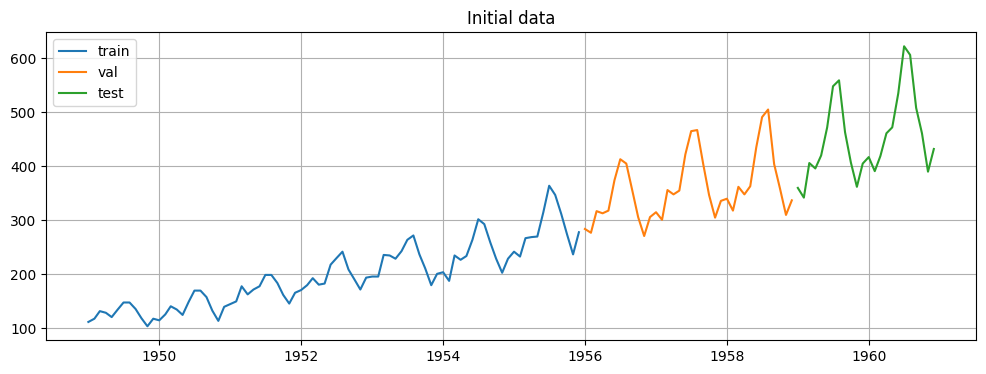

In [ ]:
def initial_data_display(split):
    plt.figure(figsize=(12, 4))
    for part in split:
        plt.plot(split[part]["timestamps"], split[part]["data"], label=part)
    plt.title("Initial data")
    plt.legend()
    plt.grid()
    plt.show()


initial_data_display(split)

### Устранение тренда

Для обработки данных нейронной сетью требуется, чтобы распределение входных и целевых переменных в обучающей, валидационной и тестовой выборках было одинаковым.

Для устранения гетероскедастичности и линейного тренда реализуем класс, с помощью которого мы сможем:

* при необходимости применять к данным логарифмирование для устранения гетероскедастичности (флаг `apply_log`),
* проводить оценку и вычитание линейного тренда с помощью методов `fit` и `transform`,
* проводить обратное преобразование: прибавление тренда и экспоненцирование (если изначально проводилось логарифмирование) с помощью метода `inverse_transform`.

In [ ]:
from sklearn.linear_model import LinearRegression


class TimeSeriesTransform:
    def __init__(self, apply_log=False):
        self.slope = None
        self.apply_log = apply_log

    def fit(self, train_data: np.ndarray):
        data = train_data
        if self.apply_log:
            data = np.log(data + 1)  # to avoid log(0)

        x = np.arange(len(data))
        x_centered = x - x.mean()

        data_centered = data - data.mean()

        reg = LinearRegression(fit_intercept=False).fit(
            x_centered.reshape(-1, 1), data_centered.reshape(-1, 1)
        )

        self.slope = reg.coef_[0]

        return self

    def transform(self, data: np.ndarray, window_size: int):
        if self.slope is None:
            raise ValueError("call fit before transform")

        if self.apply_log:
            data = np.log(data + 1)  # to avoid log(0)

        x = np.arange(len(data))
        x_centered = x - x.mean()
        trend = self.slope * x_centered

        anchor_value = data[window_size]
        data_centered = data - data.mean()
        data_detrended = data_centered - trend
        return anchor_value, data_detrended

    def inverse_transform(self, anchor_value: float, data_detrended: np.ndarray):
        if self.slope is None:
            raise ValueError("call fit before inverse_transform")

        x = np.arange(len(data_detrended))
        x_centered = x - x.mean()
        trend = self.slope * x_centered

        data = data_detrended + trend
        data = data - data[0] + anchor_value
        if self.apply_log:
            data = np.exp(data) - 1
        return data

Применим логарифмирование, оценим линейный тренд на обучающих данных и проведем его вычитание на обучающих, валидационных и тестовых данных.

Неочевидный момент: наличие линейного тренда приводит нас к необходимости уметь экстраполировать линейный тренд в область за пределами обучающих данных, на которых мы его оцениваем. Потому при вызове `transform` мы храним опорную точку (`anchor_value`) для каждой из подвыборок, чтобы знать, в каком масштабе нужно добавлять тренд в дальнейшем при вызове `inverse_transform`.



In [ ]:
window_size = 12

split["train"]["transform"] = TimeSeriesTransform(apply_log=True)

split["train"]["transform"].fit(split["train"]["data"])

for part in split:
    split[part]["anchor_value"], split[part]["data_transformed"] = split["train"][
        "transform"
    ].transform(split[part]["data"], window_size=window_size)

Отобразим преобразованные данные, на которых теперь можно обучать, валидировать и тестировать нейронную сеть:

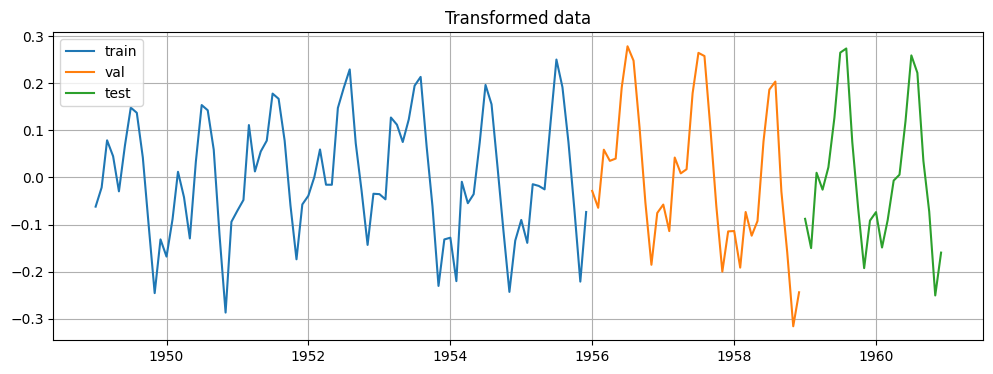

In [ ]:
def transformed_data_display(split):
    plt.figure(figsize=(12, 4))
    for part in split:
        plt.plot(split[part]["timestamps"], split[part]["data_transformed"], label=part)
    plt.title("Transformed data")
    plt.legend()
    plt.grid()
    plt.show()


transformed_data_display(split)

### Создание датасета

Создадим датасет: будем обучать нейронную сеть по последовательности из `seq_len` элементов предсказывать `seq_len + 1`-й

In [ ]:
import torch
from torch.utils.data import Dataset


class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        super().__init__()
        self.seq_length = seq_length
        self.data = torch.from_numpy(data).float()

    def __getitem__(self, idx):
        # seq_len elements input
        x = self.data[idx : (idx + self.seq_length)].view(-1, 1)
        # one element output
        y = self.data[idx + self.seq_length]
        return x, y

    def __len__(self):
        return len(self.data) - self.seq_length

Для каждой части данных создадим `Dataset` и `DataLoader`:

In [ ]:
from torch.utils.data import DataLoader

for part in split:
    split[part]["dataset"] = TimeSeriesDataset(
        data=split[part]["data_transformed"], seq_length=window_size
    )

    shuffle = True if part == "train" else False

    split[part]["dataloader"] = DataLoader(
        dataset=split[part]["dataset"], batch_size=16, shuffle=shuffle
    )

Посмотрим на один батч обучающих данных, а также выведем количество обучающих батчей:

In [ ]:
x, y = next(iter(split["train"]["dataloader"]))

print(f"one batch input shape:   {x.shape}")
print(f"one batch output shape:  {y.shape}")
print(f"number of train batches: {len(split['train']['dataloader'])}")

one batch input shape:   torch.Size([16, 12, 1])
one batch output shape:  torch.Size([16])
number of train batches: 5


### Создание модели

Модель рекуррентной нейронной сети будет содержать два слоя:

* рекуррентный скрытый слой из `hidden_size` рекуррентных нейронов, который будет получать последовательность из `seq_len` отсчетов временного ряда (так как мы имеем дело со скалярным рядом, то размерность `input_size` в данном примере равна $1$) и производить `seq_len` скрытых состояний,
* полносвязный слой, который будет по последнему скрытому состоянию последовательности предсказывать одно число &mdash; следующий отсчет временного ряда.

In [ ]:
import torch.nn as nn


class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=16):
        # hidden_size it is number of hidden neurons
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        # Predict only one value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: [b_s, seq_len, input_size]  b_s <= batch_size
        out, h = self.rnn(x)  # [b_s, seq_len, hidden_size], [1, b_s, hidden_size]
        y = self.fc(h)  # [1, b_s, 1]
        y = y.flatten()  # [b_s]
        return y

Проверим, что входные данные одного батча проходят через модель.

In [ ]:
model = TimeSeriesPredictor()
out = model(x)

print(f"Model output size: {out.shape} (bach_size x out_dim)")

Model output size: torch.Size([16]) (bach_size x out_dim)


### Получение предсказаний

Предсказывать следующие значения временного ряда с помощью модели можно в двух режимах:

* "forced prediction" — для предсказания на вход всегда подаются актуальные значения ряда,
* "rolling prediction" — для предсказания в будущее, когда актуальных значений ряда нет на руках, можно подавать модели на вход ее собственные предсказания. Таким образом технически возможно предсказывать на произвольное количество отсчетов в будущее.

Для честной оценки модели на тестовых данных нужно пользоваться именно "rolling prediction": подаем модели первые `seq_len` отсчетов актуальных данных для получения первого предсказания, а для получения следующих предсказаний подаем модели на вход ее же выход.

Обратим внимание, что модель работает с предобработанными данными, поэтому после получения предсказаний требуется вызвать `inverse_transform` для возврата к исходным значениям.

In [ ]:
def forced_predict(model, split, part):
    y_true = []
    y_pred = []
    model.eval()
    dataset = split[part]["dataset"]
    with torch.no_grad():
        for x, y in dataset:
            out = model(x)
            y_true.append(y.item())
            y_pred.append(out.item())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    transform = split["train"]["transform"]
    y_true = transform.inverse_transform(split[part]["anchor_value"], y_true)
    y_pred = transform.inverse_transform(split[part]["anchor_value"], y_pred)

    return y_true, y_pred

In [ ]:
def rolling_predict(model, split, part, forecast_horizon):
    y_pred = []
    model.eval()
    dataset = split[part]["dataset"]
    x, _ = dataset[0]

    with torch.no_grad():
        for _ in range(forecast_horizon):
            out = model(x).view(-1, 1)  # for concatenation shape compatibility
            y_pred.append(out.item())

            # drop first element and add new prediction
            x = torch.cat([x[1:], out])
    y_pred = np.array(y_pred)

    transform = split["train"]["transform"]
    y_pred = transform.inverse_transform(split[part]["anchor_value"], y_pred)

    return y_pred

Для проверки получим предсказания необученной модели: в режиме "forced prediction" для обучающих и валидационных данных и в режиме "rolling prediction" для тестовых.

In [ ]:
for part in split:
    if part in ("train", "val"):
        y_true, y_pred = forced_predict(model, split, part)

    if part == "test":
        y_true, _ = forced_predict(model, split, part)
        y_pred = rolling_predict(model, split, part, forecast_horizon=len(y_true))

    split[part]["y_true"] = y_true
    split[part]["y_pred"] = y_pred

Отобразим актуальные и предсказанные данные. Так как для тестовых данных мы можем получать предсказания длиннее, чем актуальные данные, для отображения дат по оси $x$ создается `pd.date_range` [🛠️[doc]](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html) с началом, совпадающим с началом актуальных тестовых данных, и длиной с предсказанные тестовые данные.

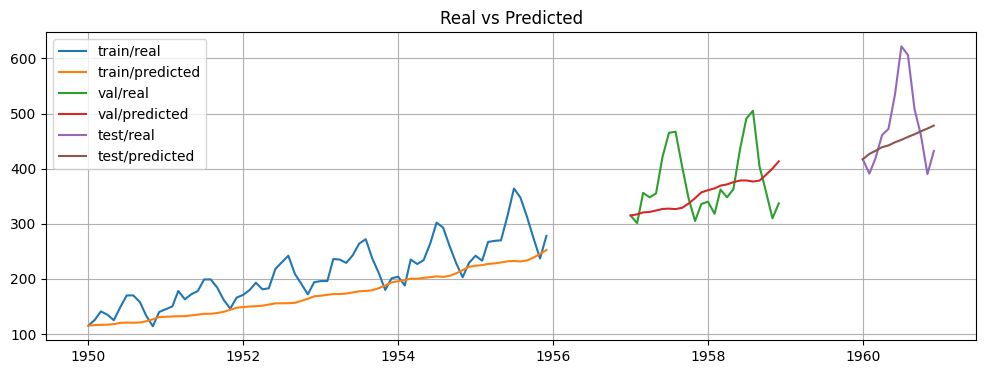

In [ ]:
def display_pred_with_rolling_test(split):
    plt.figure(figsize=(12, 4))
    for part in split:
        timestamps = split[part]["timestamps"][window_size:]
        real_data = split[part]["y_true"]
        pred_data = split[part]["y_pred"]

        if part in ("train", "val"):

            plt.plot(timestamps, real_data, label=f"{part}/real")
            plt.plot(timestamps, pred_data, label=f"{part}/predicted")

        if part == "test":
            plt.plot(timestamps, real_data, label=f"{part}/real")

            future_timestamps = pd.date_range(
                timestamps.iloc[0], periods=len(pred_data), freq="MS"
            )
            plt.plot(future_timestamps, pred_data, label=f"{part}/predicted")

    plt.title("Real vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()


display_pred_with_rolling_test(split)

Оценим ошибку RMSE для предсказаний необученной модели:

In [ ]:
from sklearn.metrics import root_mean_squared_error

for part in split:
    part_rmse = np.sqrt(
        root_mean_squared_error(
            y_true=split[part]["y_true"],
            y_pred=split[part]["y_pred"],
        )
    )
    print(f"{part:<5} RMSE: {part_rmse:.2f}")

train RMSE: 6.95
val   RMSE: 8.23
test  RMSE: 8.81


### Обучение

Реализуем пайплайн обучения и валидации на Lightning. В качестве функции потерь и метрики будем использовать MSE.

In [ ]:
!pip install -q lightning==2.5.0 tbparse

In [ ]:
import lightning as L
from torchmetrics import MetricCollection
from torchmetrics.regression import MeanSquaredError


class TimeSeriesPipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.MSELoss(),
        optimizer_class=torch.optim.Adam,
    ):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        metrics = MetricCollection([MeanSquaredError()])
        self.train_metrics = metrics.clone(postfix="/train")
        self.valid_metrics = metrics.clone(postfix="/val")

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters())
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)

        self.log("Loss/train", loss, prog_bar=True)
        self.train_metrics.update(out, y)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("Loss/val", loss, prog_bar=True)
        self.valid_metrics.update(out, y)

    def on_training_epoch_end(self):
        train_metrics = self.train_metrics.compute()
        self.log_dict(train_metrics)
        self.train_metrics.reset()

    def on_validation_epoch_end(self):
        valid_metrics = self.valid_metrics.compute()
        self.log_dict(valid_metrics)
        self.valid_metrics.reset()

Создадим пайплайн и запустим обучение с сохранением лучшей модели по минимальному MSE на валидационной выборке.

In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger


L.seed_everything(42)

checkpoint_callback = ModelCheckpoint(
    monitor="MeanSquaredError/val", mode="min", filename="best"
)

exp_name = f"baseline"
trainer = Trainer(
    max_epochs=3000,
    logger=TensorBoardLogger(save_dir=f"logs/time_series_prediction", name=exp_name),
    num_sanity_val_steps=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=5,
    enable_progress_bar=False,
)

model = TimeSeriesPredictor()

pipeline = TimeSeriesPipeline(
    model=model,
    optimizer_class=torch.optim.Adam,
)

trainer.fit(
    model=pipeline,
    train_dataloaders=split["train"]["dataloader"],
    val_dataloaders=split["val"]["dataloader"],
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | TimeSeriesPredictor | 321    | train
1 | criterion     | MSELoss             | 0      | train
2 | train_metrics | MetricCollection    | 0      | train
3 | valid_metrics | MetricCollection    | 0      | train
--------------------------------------------------------------

In [ ]:
from tbparse import SummaryReader


def tbparse_visual(log_path):
    reader = SummaryReader(log_path)
    df = reader.scalars

    plt.figure(figsize=(12, 4))
    for tag in df.tag.unique():
        if "Loss" in tag:
            tag_data = df.query("`tag` == @tag").sort_values(by="step")
            tag_data = tag_data.value.values
            plt.plot(tag_data, label=tag)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.grid()
    plt.show()

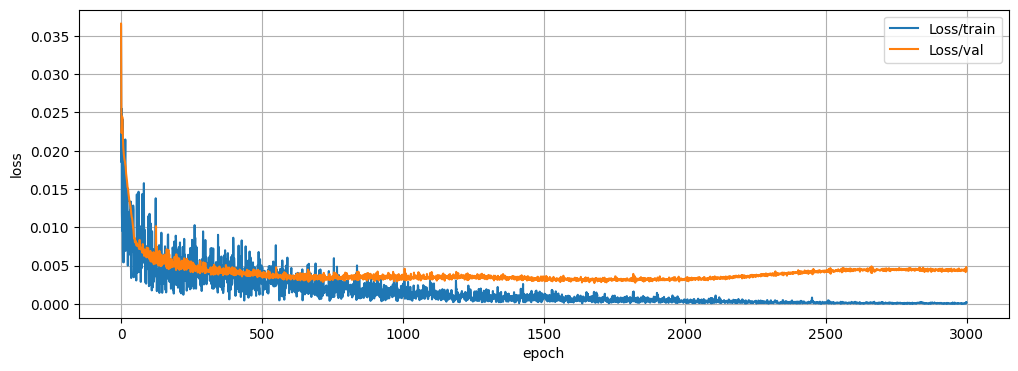

In [ ]:
import os

base_path = f"/content/logs/time_series_prediction/{exp_name}"
last_version = sorted(os.listdir(base_path))[-1]
log_path = f"{base_path}/{last_version}"

tbparse_visual(log_path)

# or simply uncomment these two lines
# %load_ext tensorboard
# %tensorboard --logdir logs/time_series_prediction --port 6006

#### Восстановление модели из контрольной точки

Так как модель могла переобучиться, восстановим модель с лучшим значением MSE на валидационной выборке.

In [ ]:
ckpt_path = f"{log_path}/checkpoints/best.ckpt"
checkpoint = torch.load(ckpt_path, weights_only=True)

print(f"Checkpoint has been loaded from {ckpt_path}")
print(f"Best model has been saved on the {checkpoint['epoch']} epoch")

state_dict = {}
for key in checkpoint["state_dict"].keys():
    key_new = key.lstrip("model.")
    state_dict[key_new] = checkpoint["state_dict"][key]

model = TimeSeriesPredictor()

model.load_state_dict(state_dict)

Checkpoint has been loaded from /content/logs/time_series_prediction/baseline/version_0/checkpoints/best.ckpt
Best model has been saved on the 1679 epoch


<All keys matched successfully>

### Предсказания обученной модели

Получим и отобразим предсказания обученной модели: в режиме "forced prediction" для обучающих и валидационных данных и в режиме "rolling prediction" для тестовых.

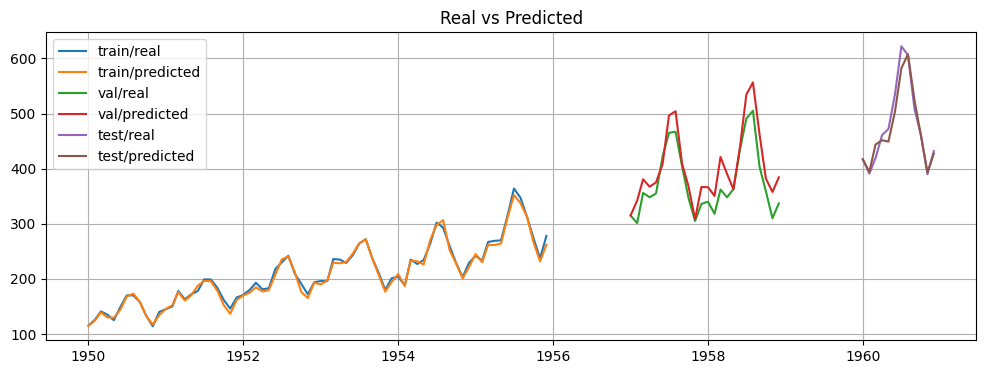

In [ ]:
for part in split:
    if part in ("train", "val"):
        y_true, y_pred = forced_predict(model, split, part)

    if part == "test":
        y_true, _ = forced_predict(model, split, part)
        y_pred = rolling_predict(model, split, part, forecast_horizon=len(y_true))

    split[part]["y_true"] = y_true
    split[part]["y_pred"] = y_pred

display_pred_with_rolling_test(split)

Оценим ошибку RMSE для предсказаний обученной модели

In [ ]:
for part in split:
    part_rmse = root_mean_squared_error(
        y_true=split[part]["y_true"], y_pred=split[part]["y_pred"]
    )
    print(f"{part:<5} RMSE: {part_rmse:.2f}")

train RMSE: 5.79
val   RMSE: 33.61
test  RMSE: 18.41


Мы можем получить предсказания в режиме "rolling prediction" и для обучающих и валидационных данных. Для примера также получим предсказания на тестовых данных еще на 4 года вперед.

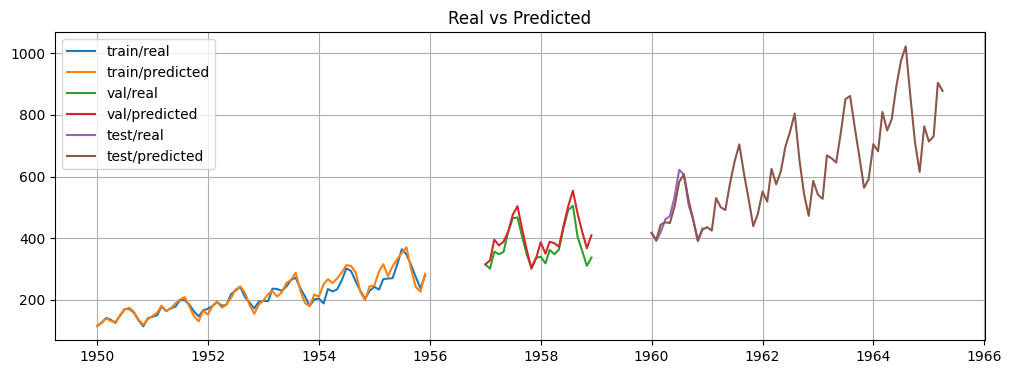

In [ ]:
for part in split:
    if part in ("train", "val"):
        y_true, _ = forced_predict(model, split, part)
        y_pred = rolling_predict(model, split, part, forecast_horizon=len(y_true))

    if part == "test":
        y_true, _ = forced_predict(model, split, part)
        y_pred = rolling_predict(model, split, part, forecast_horizon=64)

    split[part]["y_true"] = y_true
    split[part]["y_pred"] = y_pred

display_pred_with_rolling_test(split)

На "честном" предсказании на обучающих данных видно, что чем дальше модель предсказывает по своим собственным предсказаниям, тем менее точным становится прогноз. Также мы наблюдаем, что модель смогла выучить сезонность в данных: годичные колебания сохраняются.

**Замечания:**

1. Сложность нейронной сети должна соответствовать сложности подаваемых в нее данных. С ростом размерности скрытого состояния (числа рекуррентных нейронов) увеличивается количество параметров, растет возможность модели заучивать тренировочную выборку и теряется способность к обобщению.
2. Предварительный анализ цикличности в данных (если она есть) помогает понять оптимальный размер ансамбля (тут видно, что цикл в среднем составляет 12 отсчетов).
3. Как можно заметить, основная сложность работы с временным рядом лежит в пред- и постобработке сигналов. Сама нейронная сеть и ее обучение являются техническим моментом.

## Проблемы RNN

Теоретически, можно было бы сразу пропустить все данные через сеть и затем вычислить градиент, однако возникнут следующие проблемы:

 - большие последовательности не поместятся в памяти,
 - так как цепочка будет очень длинной, возникнет затухание/взрыв градиента,
 - по мере прохождения сигнала по цепи контекст затирается.


Допустим, у нас есть длинная последовательность. Если мы сразу предсказываем, то в каждый момент времени нужно распространить Loss. И все ячейки нужно обновить во время backpropogation. Все градиенты нужно посчитать. Возникают проблемы, связанные с нехваткой памяти.

Есть специальные тесты для проверки, контекст какой длины использует RNN при предсказании. Если мы делаем предсказание только в последней ячейке, может оказаться, что используется, скажем, информация только о последних 10 словах предложения.

Функция активации Tanh постепенно затирает контекст.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/backprop_through_time.png"><center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2021/lecture_10.pdf">CS231n: Recurrent Neural Network</a></em></center>

Затухающий/взрывающийся градиент (Vanishing/exploding gradient) — явления затухающего и взрывающегося градиента часто встречаются в контексте RNN. И при большой длине последовательности это становится критичным. Причина в том, что зависимость величины градиента от числа слоёв экспоненциальная, поскольку веса умножаются многократно.

$dL ∝ (W)^N:$

$W > 1 \rightarrow$ взрыв, $W < 1 \rightarrow$ затухание.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/simple_rnn_backprop.png" width="1000">

Один из путей решения проблемы — **градиентное отсечение** (Gradient truncating) — метод, который ограничивает максимально допустимое значение градиента, позволяя избежать градиентного взрыва.

## LSTM (Long Short-Term Memory)

Обычная RNN имела множество проблем, в том числе в ней очень быстро затухала информация о предыдущих элементах последовательности. Помимо этого были проблемы с затуханием/взрывом градиента.

Эти проблемы были частично решены в LSTM, предложенной в [Long Short-Term Memory (Hochreiter & Schmidhuber, 1997) 🎓[article]](http://www.bioinf.jku.at/publications/older/2604.pdf).

В обычной RNN-ячейке был только один путь передачи информации. На каждом шаге мы конкатенировали предыдущее скрытое состояние с текущим входом и пропускали их через линейный слой и активацию:

<div align="center">
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
<font size="2" face="Times New Romans" >


</style>
</head>
<body>

<table >

<tr>
<td>

<center><img src = "https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/simple_rnn_h_state.png" width="500"></center>

</td>
<td>

<table >
<tr>
<td>

$\large h_t = \tanh(W \cdot [h_{t-1}, x_t])$

</td>

</tr>


</table>

</td>
</tr>

</table>








При этом информация о предыдущих элементах последовательности очень быстро затухает и теряется общая информация о предложении.

Структура ячейки LSTM намного сложнее. Здесь есть целых 4 линейных слоя, каждый из которых выполняет разные задачи.

<div align="center">
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
<font size="2" face="Times New Romans" >


</style>
</head>
<body>

<table >
<tr>
<td>

<center><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/lstm_chain.png" width="500"></center>
<center><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/lstm_chain_notation.png" width="700"></center>

</td>
<td>

<table >
<tr>
<td>

$\large f_t = σ(W_f \cdot [h_{t-1}, x_t])\ \ \ \ $

</td>
<td>

$$\large \text{forget  gate}$$

</td>
</tr>

<tr>
<td>

$\large i_t = σ(W_i \cdot [h_{t-1}, x_t])$

</td>
<td>

$$\large \text{input gate}$$

</td>
</tr>

<tr>
<td>

$\large o_t = σ(W_o \cdot [h_{t-1}, x_t])$

</td>
<td>

$$\large \text{output gate}$$

</td>
</tr>

<tr>
<td>

$\large c^\prime_t = \tanh(W_c \cdot [h_{t-1}, x_t])$

</td>
<td>

$$\large \text{candidate cell state}$$

</td>
</tr>

<tr>
<td>

$\large c_t = f_t\otimes c_{t-1} + i_t \otimes c^\prime_t$

</td>
<td>

$$\large \text{cell state}$$

</td>
</tr>

<tr>
<td>

$\large h_t = o_t\otimes \tanh(c_t)$

</td>
<td>

$$\large  \text{hidden state}$$

</td>
</tr>
</table>

</td>
</tr>

</table>








Главное нововведение: в LSTM добавлен путь $c$, который по задумке должен этот общий контекст сохранять.

<center><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/lstm_c_state_highway.png" width="500"></center>

Другими словами, путь $c$ (cell state, иногда называется highway, магистраль)  помогает нейросети сохранять важную информацию, встретившуюся в какой-то момент в последовательности в прошлом, все время, пока эта информация требуется.

По формулам также видно, как возросла сложность.

Отличие от RNN состоит в том, что кроме $h$ возвращается еще и $c$.

In [ ]:
import torch.nn as nn


lstm = nn.LSTM(input_size=3, hidden_size=2, batch_first=True)
input = torch.randn(16, 57, 3)  # batch_size, seq_len, input_size
out, (h, c) = lstm(input)  # h and c returned in tuple

print("Input shape:".ljust(15), input.shape)
print("Shape of h".ljust(15), h.shape)  # 1, batch_size, hidden_size
print("Shape of c".ljust(15), c.shape)  # 1, batch_size, hidden_size
print("Output shape:".ljust(15), out.shape)  # batch_size, seq_len, hidden_size

Input shape:    torch.Size([16, 57, 3])
Shape of h      torch.Size([1, 16, 2])
Shape of c      torch.Size([1, 16, 2])
Output shape:   torch.Size([16, 57, 2])


## GRU (Gated Recurrent Unit)

Самая известная модификация LSTM — GRU. Она более компактна за счет сильных упрощений в сравнении со стандартной LSTM.

Главные изменения: объединены forget и input gates, слиты $h_t$ и $c_t$, которые в обычной LSTM только участвовали в формировании друг друга.

<div align="center">
<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
<font size="2" face="Times New Romans" >


</style>
</head>
<body>

<table >
<tr>
<td>

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/gru_basic_block.png" width="500"></center>

</td>
<td>

<table >
<tr>
<td>

$\large z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$

</td>

</tr>

<tr>
<td>

$\large r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$

</td>

</tr>

<tr>
<td>

$\large \tilde h_t = \tanh(W \cdot [r_t \otimes h_{t-1}, x_t])$

</td>

</tr>

<tr>
<td>

$\large h_t = (1-z_t) \otimes h_{t-1} + z_t \otimes \tilde h_t$

</td>


</table>








</td>
</tr>

</table>








In [ ]:
gru = nn.GRU(input_size=3, hidden_size=2, batch_first=True)
input = torch.randn(16, 57, 3)  # batch_size, seq_len, input_size
out, h = gru(input)

print("Input shape:".ljust(15), input.shape)
print("Shape of h:".ljust(15), h.shape)  # 1, batch_size, hidden_size
print("Output shape:".ljust(15), out.shape)  # batch_size, seq_len, hidden_size

Input shape:    torch.Size([16, 57, 3])
Shape of h:     torch.Size([1, 16, 2])
Output shape:   torch.Size([16, 57, 2])


Практический опыт исследователей: иногда лучше работает GRU, иногда — LSTM. Точный рецепт успеха сказать нельзя.

# Обработка естественного языка (NLP)

Мы рассмотрели применение рекуррентных нейронных сетей для **прогнозирования временного ряда**. Эта архитектура может использоваться и для других типов задач, связанных с последовательными данными: от **распознавания речи** до **генерации подписей** к изображениям. Общим для них является необходимость работы с **контекстом**: информация, сформированная при обработке одной части данных, релевантна для обработки других частей.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/sequence_data.png" width="1000"></center>

Один из типов данных, по своей природе являющихся последовательностями, — это **текстовые данные**. Тексты являются последовательностями слов, которые находятся между собой в сложных взаимосвязях: семантических, синтаксических, орфорграфических и так далее.

С использованием текстовых данных можно решать множество различных задач: анализ эмоциональной окрашенности текста, машинный перевод, составление аннотаций (суммаризация), создание диалоговых систем (чат-ботов), и многое-многое другое.

Для большинства этих задач можно применять технологии машинного обучения. Область, связанная с обработкой текстов на естественном языке, называется NLP — Natural language processing. C частью подходов NLP мы познакомимся на лекциях и семинарах.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/nlp_tasks.png" width="700"></center>

## Bidirectional RNN

Во временном ряде зависимость была только слева направо. Но в текстах начало или окончание предложения могут полностью изменить его смысл. Так, в задачах оценки эмоциональной окраски, можно легко ошибиться, если обрабатывать предложение только в одном направлении, постепенно забывая начало.

Двунаправленная зависимость является важнейшей особенностью, которую мы будем учитывать.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/movie_sentiment.png" width="650"></center>

Последовательность можно пропустить через рекуррентную сеть два раза: при просмотре слов в прямом и в обратном направлении. Для этого создаётся еще один рекуррентный слой, который обрабатывает последовательность в обратном направлении, а скрытые состояния двух слоёв конкатенируется.

[[blog] ✏️ Recurrent Neural Networks with PyTorch](https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/bidirectional.png" width="650"></center>

За реализацию такой двунаправленности в рекуррентных слоях отвечает флаг `bidirectional=True`.

In [ ]:
import torch

dummy_input = torch.randn((16, 57, 3))  # batch_size, seq_len, input_size
rnn = torch.nn.RNN(3, 2, bidirectional=True, batch_first=True)

out, h = rnn(dummy_input)

# Concatenated Hidden states from both layers
print("Out:\n", out.shape)
# Hidden states last element from  both : 2*num_layers*hidden_state
print("h:\n", h.shape)

Out:
 torch.Size([16, 57, 4])
h:
 torch.Size([2, 16, 2])


## Представления текстовых данных

Как и в других задачах, первым этапом идёт предобработка и очистка данных. Текстовые данные содержат различный «шум»: знаки препинания, чередование строчных и прописных символов, служебные слова. Текстовые данные необходимо упростить и привести к стандартной форме, которая подходит для используемого алгоритма.

Результатом предобработки станет набор содержательных слов нижнего регистра в начальной форме без знаков препинания.

### Предобработка текста

Стандартная процедура предварительной обработки включает следующие этапы:
- токенизация текста;
- удаление знаков препинания и чисел;
- приведение к нижнему регистру;
- удаление стоп-слов;
- стемминг или лемматизация.

Результатом станет набор содержательных слов нижнего регистра в начальной форме без знаков препинания.


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/text_preprocessing.png" width="350" ></center>


<center><em>Source: <a href="https://link.springer.com/chapter/10.1007/978-3-319-95663-3_4#citeas">Text Preprocessing</a></em></center>

Чтобы унифицировать и структурировать текст, нужно разделить его на более мелкие единицы анализа. Процесс разделения больших блоков текста (предложений, абзацев) на более маленькие единицы называется **токенизацией**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/tokenizer.png" width="700" ></center>

<center><em>Source: <a href="https://wisdomml.in/tokenization-in-natural-language-processing/">Tokenization in Natural Language Processing</a></em></center>

Разделим сейчас слова в предложении по пробелам. В этом нам поможет популярная библиотека `nltk` [🛠️[doc]](https://www.nltk.org/).

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("punkt_tab")

text = """Hey, did you know that the summer break is coming? \
Amazing right!! It's only 5 more days!!"""

tokenized_text = word_tokenize(text)
print(f"Source text: {text}")
print(f"Tokenized text: {tokenized_text}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Source text: Hey, did you know that the summer break is coming? Amazing right!! It's only 5 more days!!
Tokenized text: ['Hey', ',', 'did', 'you', 'know', 'that', 'the', 'summer', 'break', 'is', 'coming', '?', 'Amazing', 'right', '!', '!', 'It', "'s", 'only', '5', 'more', 'days', '!', '!']


Необходимо удалить элементы предложения, которые не являются словами: знаки препинания, специальные символы, числа. Они не содержат важной информации о семантике текста.

Для обеспечения непротиворечивости необходимо **привести все слова к нижнему регистру**. Этот этап повозлит уменьшить размер словаря текстовых данных.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/normalization.png" width="800" ></center>

<center><em>Source: <a href="https://devopedia.org/text-normalization">Text Normalization</a></em></center>

In [ ]:
lowercased_text = [word.lower() for word in tokenized_text if word.isalpha()]
print(f"Tokenized text: {tokenized_text}")
print(f"Lowercased text: {lowercased_text}")

Tokenized text: ['Hey', ',', 'did', 'you', 'know', 'that', 'the', 'summer', 'break', 'is', 'coming', '?', 'Amazing', 'right', '!', '!', 'It', "'s", 'only', '5', 'more', 'days', '!', '!']
Lowercased text: ['hey', 'did', 'you', 'know', 'that', 'the', 'summer', 'break', 'is', 'coming', 'amazing', 'right', 'it', 'only', 'more', 'days']


Необходимо **удалить стоп-слова** — это часто используемые слова, которые не вносят никакой дополнительной информации в текст (местоимения, предлоги). В библиотеке [NLTK 🛠️[doc]](https://www.nltk.org/) есть встроенный список стоп-слов, которым мы воспользуемся.

In [ ]:
from nltk.corpus import stopwords

nltk.download("stopwords")
print(f"Stopwords in Russian: {stopwords.words('russian')}")

Stopwords in Russian: ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'тр

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(f"Stopwords in English: {stopwords.words('english')}")

Stopwords in English: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 

In [ ]:
STOPWORDS = stopwords.words("english")
text_without_stopwords = [word for word in lowercased_text if word not in STOPWORDS]
print(f"Lowercased text: {lowercased_text}")
print(f"Text without stopwords: {text_without_stopwords}")

Lowercased text: ['hey', 'did', 'you', 'know', 'that', 'the', 'summer', 'break', 'is', 'coming', 'amazing', 'right', 'it', 'only', 'more', 'days']
Text without stopwords: ['hey', 'know', 'summer', 'break', 'coming', 'amazing', 'right', 'days']


В тексте одно и то же слово может встретиться в разной грамматической форме. Чтобы привести все токены к их словарной форме и сократить размер словаря, используется один из двух подходов для нормализации текста:

- **Лемматизация** — процесс приведения словоформы к лемме, то есть её нормальной (словарной) форме. Для его применения необходима информация о части речи и морфологической форме анализируемого слова, что требует анализа контекста.
- **Стемминг** — эвристический процесс нахождения основы для заданного слова. Он осуществляется на основе списка наиболее распространенных окончаний и словообразовательных суффиксов.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/stem_lemmatize.png" width="1000"></center>

<center><em>Source: <a href="https://towardsdatascience.com/6-nlp-techniques-every-data-scientist-should-know-7cdea012e5c3/">6 NLP Techniques Every Data Scientist Should Know</a></em></center>

Запустим стемминг и лемматизацию и посмотрим на различия.

Если у нас английский, всё довольно просто.

In [ ]:
from nltk import PorterStemmer

stemmer = PorterStemmer()
stemmed_text = [stemmer.stem(word) for word in text_without_stopwords]

print("{0:20}{1:20}".format("--Word--", "--Stem--"))
for word in text_without_stopwords:
    print("{0:20}{1:20}".format(word, stemmer.stem(word)))

--Word--            --Stem--            
hey                 hey                 
know                know                
summer              summer              
break               break               
coming              come                
amazing             amaz                
right               right               
days                day                 


С лемматизацией чуть сложнее, так как для её работы необходимо указать часть речи (**POS, Part Of Speech**). Определим POS с помощью `nltk`.


In [ ]:
from nltk import pos_tag

nltk.download("averaged_perceptron_tagger_eng")
nltk.download("tagsets_json")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets_json.zip.


True

In [ ]:
text_without_stopwords

['hey', 'know', 'summer', 'break', 'coming', 'amazing', 'right', 'days']

In [ ]:
tagged_tokens = pos_tag(word_tokenize(" ".join(text_without_stopwords)))
print(tagged_tokens)

[('hey', 'NN'), ('know', 'VBP'), ('summer', 'NN'), ('break', 'NN'), ('coming', 'VBG'), ('amazing', 'JJ'), ('right', 'NN'), ('days', 'NNS')]


Расшифруем аббревиатуры полученных частей речи.

In [ ]:
POS_names = dict(tagged_tokens).values()
for i in POS_names:
    print(nltk.help.upenn_tagset(i))

NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
None
VBP: verb, present tense, not 3rd person singular
    predominate wrap resort sue twist spill cure lengthen brush terminate
    appear tend stray glisten obtain comprise detest tease attract
    emphasize mold postpone sever return wag ...
None
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
None
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
None
VBG: verb, present participle or gerund
    telegraphing stirring focusing angering judging stalling lactating
    hankerin' alleging veering c

Воспользуемся тем, что по умолчанию у `WordNetLemmatizer` слова обрабатываются как существительные (`NOUN`), и напишем промежуточный словарик, чтобы дальше в цикле обрабатывать тексты.

In [ ]:
from nltk.corpus import wordnet as wn
from collections import defaultdict

nltk.download("wordnet")

tag_map = defaultdict(lambda: wn.NOUN)
tag_map["J"] = wn.ADJ
tag_map["V"] = wn.VERB
tag_map["R"] = wn.ADV

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from nltk import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

print("{0:20}{1:20}".format("--Word--", "--Lemma--"))
for tagged_token in tagged_tokens:
    word = tagged_token[0]
    word_pos = tagged_token[1]
    lemma = lemmatizer.lemmatize(word, pos=tag_map[word_pos])
    print("{0:20}{1:20}".format(word, lemma))

--Word--            --Lemma--           
hey                 hey                 
know                know                
summer              summer              
break               break               
coming              coming              
amazing             amazing             
right               right               
days                day                 


Полноценной поддержки русского языка в библиотеке NLTK нет. Для стемминга можно использовать `SnowballStemmer`, который является адаптацией классичего алгоритма `PorterStemmer`.

Для лемматизации можно воспользоваться пакетом [pymorphy3 🛠️[doc]](https://github.com/no-plagiarism/pymorphy3).

На практике часто используют другой подход, основанный на частотном анализе текста, а именно TF-IDF.

### Векторизация текста

Методы машинного обучения работают с числами. Нам нужно найти способы, которые позволят представлять тексты в виде числовых данных.

Если объектом является текст, в качестве признаков выступают слова, которые он содержит. Процесс преобразования текста в числа называется **векторизацией**.

#### Bag-of-words

В этой модели создаётся словарь уникальных слов, а текст представляется в виде вектора размером со словарь с мерой присутствия (числом) таких слов в тексте без какого-либо учета грамматики и порядка слов.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/bag_of_words_representation.png" width="800"></center>

#### TF-IDF

**TF-IDF** — способ численного представления документа, оценивает  **важность слова в контексте документа**. Состоит из двух множителей: **TF** и **IDF**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/tf_idf.png" width="500"></center>




Первая идея **TF-IDF** — **если слово часто встречается в документе, оно важное**. За это отвечает TF.

**TF (term frequency)** — частота вхождения слова в документ, для которого рассчитывается значение:

$$\large \text{TF}(t, d) = \frac{n_t}{\sum_{k}n_k},$$

где $n_t$ — количество повторов слова $t$ в документе $d$,

$\sum_{k}n_k$ — общее количество слов  $t$ в документе $d$ с повторами.

Вторая идея **TF-IDF** — **если слово встречается во многих документах, его ценность снижается**.

Пример: местоимения встречаются в большинстве текстов, но не несут смысловой нагрузки. За это отвечает IDF.

**IDF (inverse document frequency)** — логарифм обратной частоты вхождения слова в документы:

$$\large \text{IDF}(t, D) = \log{\frac{|D|}{|\{d_i \in D| t \in d_i \}|}},$$

где $|D|$ — число документов в коллекции,
$|\{d_i \in D| t \in d_i \}|$ — число документов в коллекции со словом $t$.


Итоговая формула:
$$\large \text{TF-IDF}(t, d, D) = \text{TF}(t,d)⋅\text{IDF}(t, D)$$

Пример работы `TfidfVectorizer` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) из Sklearn.
Каждому документу сопоставляется вектор, равный длине словаря. Ненулевые значения вектора хранятся в виде разреженных матриц `scipy.sparse.csr_matrix` [🛠️[doc]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(corpus)

print("Tf-idf dictionary:", vectorizer.get_feature_names_out())
print("Tf-idf dictionary len:", len(vectorizer.get_feature_names_out()))
print("Tf-idf shape:", x.shape)

Tf-idf dictionary: ['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
Tf-idf dictionary len: 9
Tf-idf shape: (4, 9)


**На практике:**

1. Тексты токенизируются и нормализуются. Если мы решаем работать с N-граммами, то вместо токенизации или после неё выделяем N-граммы.

2. Проходимся по всей коллекции документов и для каждого слова подсчитываем, в каком количестве документов оно встретилось. Если у нас большая коллекция, то словарь может получиться просто гигантским, особенно если мы работаем с N-граммами, поэтому периодически, во время построения или после этой процедуры, мы должны выбросить из словаря всё, что считаем неинформативным, — слишком редкие и слишком частые слова.

3. Затем начинаем строить матрицу признаков. Каждая строчка этой матрицы соответствует документу, а каждый столбец — статистике встречаемости этого слова в документе. Таким образом, для каждого документа мы считаем частоты слов в нём и записываем в соответствующие ячейки таблицы веса слов по указанной формуле.

4. Переходим к следующему документу.

Таким образом, TF-IDF — это способ взвешивания и отбора категориальных признаков в задачах машинного обучения, не только в классификации и не только для текстов. Надо заметить, что TF-IDF никак не использует информацию о метке объекта — это одновременно и преимущество, и недостаток. Преимущество заключается в том, что мы можем использовать TF-IDF, не имея меток, то есть в задачах обучения без учителя. Недостаток — в том, что мы теряем информацию или недостаточно эффективно её используем.

**Когда TF-IDF может быть неэффективен:**

1. **Отсутствие семантической информации**: TF-IDF не учитывает семантические связи между словами, что может привести к ограниченной способности понимания смысла текста.

2. **Чувствительность к длине** документа: длинные документы могут иметь более высокие значения TF, даже если ключевые слова встречаются реже. В таких случаях TF-IDF может недооценить важность конкретных слов.

#### Word2Vec

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/w2v_example.png" width="350"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/585838/">Семантика и технология Word2Vec</a></em></center>



Word2Vec (w2v) — способ представления слов в многомерном векторном пространстве, предложенный в статье [Efficient Estimation of Word Representations in Vector Space (Mikolov et al., 2013) 🎓[article]](https://arxiv.org/pdf/1301.3781).

**Векторные представления слов называются эмбеддингами.**

Word2Vec реализуется при помощи полносвязной нейронной сети из двух слоев, которая обрабатывает текст, преобразуя его в числовые “векторизованные” слова. Основной особенностью w2v стало добавление контекста: нейросеть использует информацию о том, какие слова находятся рядом в заданном окне.

Входные данные w2v — это громадный текстовый корпус, из которого на выходе мы получаем пространство векторов, размерность которого обычно достигает сотен, где каждое уникальное слово в корпусе представлено вектором из сгенерированного пространства.

Есть два основных способа реализации Word2Vec: **Skip-Gram** и **CBOW**.

* **Слева** расположен метод **Skip-Gram**, в котором мы передаем какое-то слово нашей нейронной сети и просим ее предположить возможный контекст. $w[i]$ — слово, которое передается на вход и которое находится на позиции $i$ в предложении. На выходе имеем два предшествующих слова и два последующих слова с учетом позиции $i$.

* **Справа — CBOW** (Continuous Bag of Words). Здесь, вместо того, чтобы предугадывать контекстные слова, добавляем их в модель и просим модель предсказать текущее слово.

Фокус состоит в том, что на самом деле никакой обученной нейросети у нас нет. Здесь другая цель — изучить веса скрытого слоя по мере того, как корректируются спрогнозированные веса окружающих слов. Эти веса и есть эмбеддинги.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/skip_gram_vs_cbow.png" width="750"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/778048/">Краткий обзор техник векторизации в NLP</a></em></center>

**Данные**

Исходные, "сырые" данные представляют собой предложение

**The quick brown fox jumps over the lazy dog**.

Оставляя за скобками приведение к каноничным формам, создаем датасет так:
1. Проходим по тексту окном заданного размера (в данном случае размер окна 2 означает 2 слова слева и два слова справа от текущего).
2. Относительно текущей позиции формируем пары "текущее слово-соседнее слово" (биграммы).
3. Смещаем окно вправо.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out//vectorization_example.png" width="900"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/778048/">Краткий обзор техник векторизации в NLP</a></em></center>


Рассмотрим, как учится сеть для варианта Skip-Gram. На вход сети приходит One-Hot вектор первого слова из биграммы, преобразовывается в пространство эмбеддингов в скрытом слое и поступает на слой SoftMax (размером с весь словарь, т.е. размер входа равен размеру выхода).

По факту нейросеть должна выучить вероятность существования слова *quick* при приходе на вход слова *fox*. При этом можно отметить, что слову *fox* также соответствуют слова *brown, jumps, over*. Обучаясь по кросс-энтропии, последний слой должен выдавать примерно одинаковые вероятности всех этих слов.


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/skip_gram_example.png" width="900"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/778048/">Краткий обзор техник векторизации в NLP</a></em></center>

В результате обучения на разнообразных данных сеть выучивает такие распределения, что вектора, соответствующие похожим словам, располагаются близко в новом пространстве, и над ними работают векторные операции.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/w2v_example_2.png" width="500"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/446530/">Word2vec в картинках</a></em></center>


Разумеется, эти операции не приводят к точному соответствию, однако получаемые вектора оказываются самыми похожими.

Обучение CBOW несколько отличается. На вход сети подаётся $C$ контекстных слов в виде One-Hot, после перемножения с линейным слоем результат усредняется. На выходе слой SoftMax такого же размера.

[[colab] 🥨 Подробное руководство по использованию Word2Vec](https://colab.research.google.com/drive/1OJF0k-E60sp9Vyoj1yWuoedGTrwRiTyj?usp=sharing)

Иначе векторное представление слов после Word2Vec можно проиллюстрировать так: **(king - man) + woman = queen**

<center><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/word2vec_example.png" width="1000"></center>

Убедимся в правильности данных арифметических операций с векторными преставлениями `Word2Vec` в коде:

Алгоритм GloVe (Global Vectors) является развитием word2vec. Он использует статистическую информацию о частоте встречаемости слов и фраз в тексте, чтобы улучшить обучение эмбеддингов редких слов. Это достигается за счет корректировки loss-функции, используемой для обучения.

Данный алгоритм реализован в нескольких библиотеках. Например, можно воспользоваться библиотекой [Gensim 🛠️[doc]](https://radimrehurek.com/gensim/auto_examples/index.html#documentation), имеющей множество [вариантов весов 🐾[git]](https://github.com/piskvorky/gensim-data).


Так можно загрузить векторные представления с длиной 100:

```python
import gensim.downloader as api

glove = api.load(
    "glove-wiki-gigaword-100"
)  # lighter faster model, but working not so good ("glove-twitter-25")
```

В библиотеке реализована функиця `most_similar()`, позволяющая выполнять арифметические операции с векторными представлениями слов:
```python
# Result of woman + king - man:
glove.most_similar(positive=["woman", "king"], negative=["man"])
```

В рамках лекции реализуем данный функционал самостоятельно.

Напишем функцию для поиска слов, наиболее похожих по смыслу на заданные слова, на основе их векторных представлений (эмбеддингов), аналогичную встроенной в Gensim функции `most_similar()`. Для этого воспользуемся функцией `scipy.spatial.distance.cosine` из библиотеки SciPy, которая вычисляет косинусное расстояние между двумя векторами.

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine


# Function to find most similar words using scipy


def scipy_most_similar(model, positive=[], negative=[], topn=10):
    all_words = list(model.keys())
    all_vectors = np.array([model[word] for word in all_words])

    # Calculate the resulting vector
    result_vec = np.zeros_like(all_vectors[0])
    for word in positive:
        result_vec += model.get(word, 0)
    for word in negative:
        result_vec -= model.get(word, 0)

    # Compute cosine similarities using scipy
    similarities = []
    for word, vector in zip(all_words, all_vectors):
        if word in positive or word in negative:
            continue  # Skip words used in the query
        sim = 1 - cosine(
            result_vec, vector
        )  # cosine() returns distance, so we subtract from 1
        sim_rounded = round(sim.item(), 6)
        similarities.append((word, sim_rounded))

    # Return top-n most similar words
    similarities.sort(key=lambda x: -x[1])  # Sort by similarity descending
    return similarities[:topn]

Загрузим предобученную модель из упомянутого официального [репозитория 🐾[git]](https://github.com/piskvorky/gensim-data), длина вектора равна 100.

In [ ]:
# Source: https://nlp.stanford.edu/data/glove.6B.zip
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/weights/glove.6B.100d.txt

Напишем функцию для загрузки GloVe-векторов из файла:

In [ ]:
def load_glove_model(glove_file_path):
    # Print a message indicating the start of model loading
    print("Loading GloVe model...")

    # Initialize an empty dictionary to store word vectors
    model = {}

    # Open the GloVe file with UTF-8 encoding
    with open(glove_file_path, "r", encoding="utf8") as f:
        for line in f:
            # Split each line into word and vector components
            parts = line.strip().split()
            word = parts[0]  # The first element is the word
            vector = np.array(parts[1:], dtype="float32")  # The rest are vector values
            model[word] = vector  # Store the word and its vector in the dictionary

    # Print the total number of words loaded
    print(f"Loaded {len(model)} words.")

    # Return the dictionary containing the word vectors
    return model

In [ ]:
glove_model = load_glove_model("/content/glove.6B.100d.txt")

Loading GloVe model...
Loaded 400000 words.


Проведем несколько арифметических операций со словами-векторами из `glove`:

In [ ]:
print("woman + king - man:")

top_similar = scipy_most_similar(
    glove_model, positive=["woman", "king"], negative=["man"]
)
for word, sim in top_similar:
    print(f"Word: {word},  similarity: {sim}")

woman + king - man:
Word: queen,  similarity: 0.783441
Word: monarch,  similarity: 0.69338
Word: throne,  similarity: 0.683311
Word: daughter,  similarity: 0.680908
Word: prince,  similarity: 0.671314
Word: princess,  similarity: 0.664408
Word: mother,  similarity: 0.657933
Word: elizabeth,  similarity: 0.65633
Word: father,  similarity: 0.639242
Word: wife,  similarity: 0.635187


In [ ]:
print("father + daughter - son:")

top_similar = scipy_most_similar(
    glove_model, positive=["father", "daughter"], negative=["son"]
)
for word, sim in top_similar:
    print(f"Word: {word},  similarity: {sim}")

father + daughter - son:
Word: mother,  similarity: 0.956055
Word: wife,  similarity: 0.913185
Word: sister,  similarity: 0.866171
Word: grandmother,  similarity: 0.86041
Word: husband,  similarity: 0.846984
Word: her,  similarity: 0.83
Word: daughters,  similarity: 0.82293
Word: married,  similarity: 0.821556
Word: aunt,  similarity: 0.794094
Word: niece,  similarity: 0.792272


Заметим, что мы так же можем работать и изменять части речи и их формы с помощью этой векторной арифметики! Попробуем сделать герундий и превосходную форму антонима слова:

In [ ]:
print("go + doing - do:")

top_similar = scipy_most_similar(glove_model, positive=["go", "doing"], negative=["do"])
for word, sim in top_similar:
    print(f"Word: {word},  similarity: {sim}")

go + doing - do:
Word: going,  similarity: 0.804104
Word: gone,  similarity: 0.7771
Word: coming,  similarity: 0.757118
Word: getting,  similarity: 0.755284
Word: putting,  similarity: 0.736672
Word: goes,  similarity: 0.729277
Word: taking,  similarity: 0.722852
Word: turning,  similarity: 0.718355
Word: staying,  similarity: 0.713809
Word: 're,  similarity: 0.706174


In [ ]:
print("low + best - good:")

top_similar = scipy_most_similar(
    glove_model, positive=["low", "best"], negative=["good"]
)
for word, sim in top_similar:
    print(f"Word: {word},  similarity: {sim}")

low + best - good:
Word: lowest,  similarity: 0.708611
Word: high,  similarity: 0.708301
Word: highest,  similarity: 0.688446
Word: higher,  similarity: 0.687116
Word: average,  similarity: 0.657671
Word: rising,  similarity: 0.655315
Word: lower,  similarity: 0.644709
Word: below,  similarity: 0.641367
Word: drop,  similarity: 0.62571
Word: levels,  similarity: 0.622502


#### Слой эмбеддингов

Ранее мы применяли `OneHotEncoding` для представления наших слов. Проблемы возникают, когда пространство объектов начинает расти и у нас возникают огромные разреженные матрицы.

Кроме того, некоторые объекты у нас сразу могут быть ближе: семантически "король" и "королева" отличаются только полом, различие между словами "король" и "стул" заметно выше.

Поэтому мы можем переводить наши слова в векторы меньшей размерности, которые при этом будут сравнимы между собой с помощью модуля `nn.Embedding` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).

[[doc] 🛠️ Туториал PyTorch по применению эмбедингов в NLP](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)

[[blog] ✏️ Lena Voita NLP Course](https://lena-voita.github.io/nlp_course.html)

[[git] 🐾 Курс по NLP от ШАД](https://github.com/yandexdataschool/nlp_course)

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/word_representation_intro_min.png" width="600"></center>

____

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/lookup_table.gif" width="600"></center>

<center><em>Source: <a href="https://lena-voita.github.io/nlp_course/word_embeddings.html">Lena Voita NLP Course</a></em></center>

In [ ]:
# Let's say you have 2 sentences (lowercased, punctuations removed):
sentences = "i am new to pytorch i am having fun"

words = sentences.split(" ")

print(f"All words: {words} \n")

vocab = set(words)  # create a vocabulary
vocab_size = len(vocab)

print(f"Vocabulary (unique words): {vocab} \n")
print(f"Vocabulary size: {vocab_size} \n")

# map words to unique indices
word2idx = {word: ind for ind, word in enumerate(vocab)}

print(f"Word-to-id dictionary: {word2idx} \n")

encoded_sentences = [word2idx[word] for word in words]

print(f"Encoded sentences: {encoded_sentences}")

All words: ['i', 'am', 'new', 'to', 'pytorch', 'i', 'am', 'having', 'fun'] 

Vocabulary (unique words): {'fun', 'to', 'i', 'am', 'pytorch', 'new', 'having'} 

Vocabulary size: 7 

Word-to-id dictionary: {'fun': 0, 'to': 1, 'i': 2, 'am': 3, 'pytorch': 4, 'new': 5, 'having': 6} 

Encoded sentences: [2, 3, 5, 1, 4, 2, 3, 6, 0]


Теперь нейросетевой слой эмбеддингов может быть определён так:

In [ ]:
import torch.nn as nn

# let's say you want embedding dimension to be 3
emb_dim = 3

emb_layer = nn.Embedding(vocab_size, emb_dim)
word_vectors = emb_layer(torch.LongTensor(encoded_sentences))

print(f"Shape of encoded sentences: {word_vectors.shape} \n")
print(f"Shape of weigths: {emb_layer.weight.shape}")

Shape of encoded sentences: torch.Size([9, 3]) 

Shape of weigths: torch.Size([7, 3])


Этот код инициализирует эмбеддинги согласно нормальному распределению (со средним значением 0 и дисперсией 1). Таким образом, пока что никакого различия или сходства между векторами нет.

`word_vectors` — тензор размером (9, 3). 9 слов в датасете, размер 3 задан нами.

`emb_layer` имеет 1 обучаемый параметр `weight`, который по умолчанию True. Можем проверить так:

In [ ]:
emb_layer.weight.requires_grad

True

Если мы не хотим обучать этой слой (например, используем заранее обученные эмбеддинги), мы можем заморозить его веса:

In [ ]:
emb_layer.weight.requires_grad = False

Возьмём векторные представления GloVe, уже использованные выше.

У модуля `nn.Embedding` есть метод `from_pretrained`, в который можно передать предобученную матрицу эмбеддингов. При этом по умолчанию они не будут обучаться — за это отвечает флаг `freeze`.

In [ ]:
all_words = list(glove_model.keys())
all_vectors = np.array([glove_model[word] for word in all_words])
print(f"all_vectors.shape is {all_vectors.shape}")

weights = torch.FloatTensor(all_vectors)
glove_emb = nn.Embedding.from_pretrained(weights, freeze=True)

all_vectors.shape is (400000, 100)


In [ ]:
input = torch.LongTensor(encoded_sentences)
glove_emb(input).shape

torch.Size([9, 100])

Код нейросети со слоем `nn.Embedding` выглядит следующим образом:

In [ ]:
class RNN_with_Embedding_Layer(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(weights)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Forward propagate the RNN
        out, _ = self.rnn(x)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out


model = RNN_with_Embedding_Layer(input_size=100, hidden_size=128, num_classes=3)

input = input.unsqueeze(0)
print(model(input))

tensor([[-0.2196, -0.2031,  0.1464]], grad_fn=<AddmmBackward0>)


### Проблемы токенизации

Один из ключевых этапов в обработке текста — **токенизация**. На этом этапе происходит разделение текста на отдельные единицы — предложения и слова. Затем создается словарь, в который заносятся уникальные лексемы, встретившиеся в корпусе или тексте. На этих этапах можно столкнуться с несколькими проблемами.

**Проблема 1. Размер словаря**

Самый простой способ токенизации — назначить каждому уникальному слову своё число. Но есть проблема: слов и их форм миллионы, и поэтому словарь таких слов получится чересчур большим, а это будет затруднять обучение модели.

Можно разбивать текст не на слова, а на отдельные буквы (char-level tokenization), тогда в словаре будет всего несколько десятков токенов, НО в таком случае уже сам текст после токенизации будет слишком длинным, а это тоже затрудняет обучение.

**Проблема 2. Богатая морфология**

"Нейросеть", "нейросетью", "нейросетями" являются разными словами, но имеют одинаковый смысл. Эту проблему классически всегда решал этап **стемминга** (удаление суффикса и окончания) или **лемматизации** (приведение слова к канонической форме).

**Проблема 3. Сложные слова**

Но все проблемы эти этапы не решают. В германских языках (в немецком, шведском, датском) очень продуктивно образовываются новые сложные слова. Значения таких слов выводятся из значения их элементов. Их можно создавать бесконечно долго, и большинство из них не зафиксировано в «бумажном» словаре.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/swedish_word_example.png" width="600"></center>

<center><em>Пример шведского названия гаечного ключа для колеса мотоцикла</a></em></center>

<center><em>Source: <a href="https://sysblok.ru/nlp/7250/">Как работает алгоритм токенизации текстов для нейросетей</a></em></center>

При работе с этими языками сложность также возникает на этапе составления словаря. При составлении словаря модели ориентируются на частотность (например, сохраняем слово, если оно встретилось чаще пяти раз), поэтому не будут запоминать такое длинное и сложное слово.

**Проблема 4: Границы слова**

Для нас, привыкших к языкам европейского типа, слово — это набор букв между пробелами и знаками препинания. Но в английском языке многие сложные слова пишутся раздельно, а в японском, наоборот, между словами вообще нет пробелов. Поэтому универсальный токенизатор создать было нелегко.

### Byte Pair Encoding

Изначально алгоритм компрессии BPE позволяет моделям узнавать как можно больше слов при ограниченном объеме словаря.

1.   Слово = последовательность токенов
2.   Словарь = все токены
3.   Повторять, пока не достигли ограничения на размер словаря:

     назначаем новым токеном объединение двух существующих токенов, которое
встречается чаще других пар в корпусе (встречаются вместе).

В применении BPE возможны разные варианты. Один из естественных – идём по всем токенам по убыванию частоты, находим соответствующую последовательность символов в корпусе, заменяем на токен.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/subword_tokenization.png" width = "500"></center>

<center><em>Source: <a href="https://alexanderdyakonov.wordpress.com/2019/11/29/токенизация-на-подслова-subword-tokenization/">Токенизация на подслова (Subword Tokenization)</a></em></center>

Этот же способ помогает решить **проблему** **OOV (out of vocabulary)**. В обучающей выборке может не быть слова *Unfriendly*, но поскольку **Unfriendly** = **Un** + **friend** + **ly**, мы можем рассчитывать, что сеть будет правильно обрабатывать / генерировать и слово целиком.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/token_unfriendly.png" width="600"></center>

<center><em>Source: <a href="https://www.thoughtvector.io/blog/subword-tokenization/">Subword Tokenization — Handling Misspellings and Multilingual Data</a></em></center>

# Пример посимвольной генерации текста

Давайте попробуем научить модель заканчивать предложение, то есть изучить свойства конкретного языка, фактически — распределение вероятностей следущего токена на основе истории предыдущих токенов.

[[git] 🐾 RNN-walkthrough](https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb)

Эта задача сводится к посимвольной генерации текста. Как правило, конвейер обработки текста содержит в себе следующие 5 блоков. К ним, в зависимости от задачи, добавляются дополнительные пункты.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/base_nlp_pipeline.png" width="700"></center>

**Постановка задачи:** для каждого символа в последовательности предсказать следующий символ:

- исходный текст: `hey how are you`,
- входная последовательность: `hey how are yo`,
- целевая последовательность: `ey how are you`.

Очень похоже на то, что мы делали ранее с временными рядами. Однако теперь нам нужно предсказывать букву каждый раз, на каждый `hidden`. Таким образом мы приходим к схеме **many-to-many**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/one_to_many_same.png" width="300"></center>

Инференс модели будет выглядеть так:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/character_by_character_generation_example.gif" width="400"></center>

<center><em>Source: <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">The Unreasonable Effectiveness of Recurrent Neural Networks</a></em></center>

## Подготовка данных

В нашей учебной задаче мы сократим до минимума выполняемые операции по подготовке данных для модели.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/simple_pipeline.png" width="700"></center>

In [ ]:
# Source: https://tatoeba.org/ru/downloads
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/eng_sentences.txt

In [ ]:
import pprint

with open("eng_sentences.txt", "r") as input_file:
    text = [line.strip().lower() for line in input_file.readlines()]

pprint.pprint(text[:10])

['the boy opened the window, although his mother told him not to.',
 'my oldest brother attended the meeting on behalf of our father.',
 'did tom say anything about going to boston next week?',
 'northern lights appear all year round in greenland.',
 'the flight attendant apologized for spilling hot coffee on tom.',
 "there's something i need to tell you before you leave.",
 'when the judge speaks, everyone in the courtroom listens.',
 "tom's house is at least three times larger than mine.",
 'he left his hometown at the age of fifteen never to return.',
 "i've asked tom to stop calling me so late at night."]


In [ ]:
# Join all the sentences together and extract the unique characters
# from the combined sentences
chars = set("".join(text))
# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))
# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

print("Dictionary for mapping character to the integer:")
pprint.pprint(char2int)

Dictionary for mapping character to the integer:
{' ': 15,
 '!': 38,
 '"': 26,
 '$': 4,
 '%': 40,
 "'": 3,
 ',': 24,
 '-': 47,
 '.': 28,
 '0': 5,
 '1': 30,
 '2': 7,
 '3': 34,
 '4': 22,
 '5': 41,
 '6': 6,
 '7': 17,
 '8': 33,
 '9': 25,
 ':': 43,
 '?': 42,
 '@': 10,
 'a': 16,
 'b': 14,
 'c': 21,
 'd': 36,
 'e': 11,
 'f': 20,
 'g': 13,
 'h': 1,
 'i': 45,
 'j': 46,
 'k': 19,
 'l': 27,
 'm': 48,
 'n': 31,
 'o': 32,
 'p': 39,
 'q': 18,
 'r': 12,
 's': 35,
 't': 0,
 'u': 8,
 'v': 9,
 'w': 23,
 'x': 44,
 'y': 2,
 'z': 29,
 '\xa0': 49,
 '’': 37}


Вместо ASCII символа, каждой букве мы сопоставили номер.

### Выравнивание данных (Padding)

RNN допускают работу с данными переменной длины. Но чтобы поместить предложения в batch, надо их выровнять.

Обычно размер батча делают равным самому длинному предложению, а остальные просто дополняют пробелами (или спецсимволами) до этого размера.  Также хорошей идеей будет отметить специальным символом начало предложения.

In [ ]:
lengths = [len(sent) for sent in text]
maxlen = max(lengths)
print(f"The longest string has {maxlen} characters.\n")

print(f"Initial texts:\n{text}")
# A simple loop that loops through the list of sentences and adds
# a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(text)):
    while len(text[i]) < maxlen:
        text[i] += " "

print(f"Resulting texts:\n{text}")

The longest string has 69 characters.

Initial texts:
['the boy opened the window, although his mother told him not to.', 'my oldest brother attended the meeting on behalf of our father.', 'did tom say anything about going to boston next week?', 'northern lights appear all year round in greenland.', 'the flight attendant apologized for spilling hot coffee on tom.', "there's something i need to tell you before you leave.", 'when the judge speaks, everyone in the courtroom listens.', "tom's house is at least three times larger than mine.", 'he left his hometown at the age of fifteen never to return.', "i've asked tom to stop calling me so late at night.", "i wish i hadn't promised tom that i'd help him do that.", "i don't think that tom will be able to understand that.", 'the drug must go through clinical trials before being approved.', 'the house has a dining room, a bedroom and a study.', "we're really close and we tell each other everything.", "i need to call my parents and tell them 

#### Адаптивное выравнивание: Sequence bucketing


Для выравнивания данных мы поступили самым простым образом: определили максимальную длину последовательности во всем корпусе данных и дополнили все предложения пробелами до этой длины.

Однако стоит отметить, что этот подход неоптимален. При обучении неизбежно будут возникать такие батчи, длина всех объектов в которых будет меньше, чем максимальная длина по датасету. Поэтому нейронная сеть в рамках одного батча будет впустую обрабатывать лишние символы пробелов.

Технически для обучения нейронной сети необходимо обеспечить одинаковую длину последовательности только в рамках одного батча.

Поэтому существует подход, который называется **Sequence bucketing**. Он заключается в том, чтобы дополнять последовательности спецсимволами до единой длины не глобально на уровне датасета, а динамически в рамках одного батча. Это позволяет ускорить процесс обучения. Реализация этого подхода останется вне рамок нашего примера.

[[blog] ✏️ Guide: Pytorch data Samplers & Sequence bucketing](https://www.kaggle.com/code/shahules/guide-pytorch-data-samplers-sequence-bucketing)

[[blog] ✏️ Speed up your RNN with Sequence Bucketing](https://www.kaggle.com/code/bminixhofer/speed-up-your-rnn-with-sequence-bucketing)


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/rnn_batch.png" width="700"></center>

### Разбиение данных

В качестве входа будем использовать предложение без последнего символа:

**`hey how are yo`**

В качестве результата — предложение, в котором он сгенерирован:

**`ey how are you`**

In [ ]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
    input_seq.append(text[i][:-1])

    # Remove first character for target sequence
    target_seq.append(text[i][1:])

    if i < 5:
        print("Input sequence:".ljust(18), f"'{input_seq[i]}'")
        print("Target sequence:".ljust(18), f"'{target_seq[i]}'")
        print()

Input sequence:    'the boy opened the window, although his mother told him not to.     '
Target sequence:   'he boy opened the window, although his mother told him not to.      '

Input sequence:    'my oldest brother attended the meeting on behalf of our father.     '
Target sequence:   'y oldest brother attended the meeting on behalf of our father.      '

Input sequence:    'did tom say anything about going to boston next week?               '
Target sequence:   'id tom say anything about going to boston next week?                '

Input sequence:    'northern lights appear all year round in greenland.                 '
Target sequence:   'orthern lights appear all year round in greenland.                  '

Input sequence:    'the flight attendant apologized for spilling hot coffee on tom.     '
Target sequence:   'he flight attendant apologized for spilling hot coffee on tom.      '



### Кодирование

Теперь символы надо перевести в числа. Для этого мы уже построили словарь.

P.S. Запускать блок только один раз.

In [ ]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

    if i < 5:
        print("Encoded input sequence:".ljust(25), input_seq[i])
        print("Encoded target sequence:".ljust(25), target_seq[i])
        print()

Encoded input sequence:   [0, 1, 11, 15, 14, 32, 2, 15, 32, 39, 11, 31, 11, 36, 15, 0, 1, 11, 15, 23, 45, 31, 36, 32, 23, 24, 15, 16, 27, 0, 1, 32, 8, 13, 1, 15, 1, 45, 35, 15, 48, 32, 0, 1, 11, 12, 15, 0, 32, 27, 36, 15, 1, 45, 48, 15, 31, 32, 0, 15, 0, 32, 28, 15, 15, 15, 15, 15]
Encoded target sequence:  [1, 11, 15, 14, 32, 2, 15, 32, 39, 11, 31, 11, 36, 15, 0, 1, 11, 15, 23, 45, 31, 36, 32, 23, 24, 15, 16, 27, 0, 1, 32, 8, 13, 1, 15, 1, 45, 35, 15, 48, 32, 0, 1, 11, 12, 15, 0, 32, 27, 36, 15, 1, 45, 48, 15, 31, 32, 0, 15, 0, 32, 28, 15, 15, 15, 15, 15, 15]

Encoded input sequence:   [48, 2, 15, 32, 27, 36, 11, 35, 0, 15, 14, 12, 32, 0, 1, 11, 12, 15, 16, 0, 0, 11, 31, 36, 11, 36, 15, 0, 1, 11, 15, 48, 11, 11, 0, 45, 31, 13, 15, 32, 31, 15, 14, 11, 1, 16, 27, 20, 15, 32, 20, 15, 32, 8, 12, 15, 20, 16, 0, 1, 11, 12, 28, 15, 15, 15, 15, 15]
Encoded target sequence:  [2, 15, 32, 27, 36, 11, 35, 0, 15, 14, 12, 32, 0, 1, 11, 12, 15, 16, 0, 0, 11, 31, 36, 11, 36, 15, 0, 1, 11, 15, 48, 11,

**Embedding**

Теперь из чисел надо сделать вектора.

Причина — подача чисел даст модели ложное знание об отношениях между объектами по типу "*буква а в два раза больше буквы б*". Нам же нужно равномерно распределить наши представления в некотором пространстве c помощью `nn.Embedding()`.

Каждый символ закодировали вектором.
Не слишком экономно, зато удобно умножать на матрицу весов.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/language_modeling.png" width="550"></center>

In [ ]:
import torch


dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = 2048

# Convert data to tensor
input_seq = torch.Tensor(input_seq).int()
target_seq = torch.Tensor(target_seq)

train_data = torch.utils.data.TensorDataset(input_seq, target_seq)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

print(f"number of train batches: {len(train_loader)}")

number of train batches: 5


## Создание и обучение модели

In [ ]:
import torch.nn as nn


class NextCharacterGenerator(nn.Module):
    def __init__(self, num_chars, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        # symbols coding
        self.emb = nn.Embedding(num_embeddings=num_chars, embedding_dim=embedding_dim)
        # RNN Layer
        self.rnn = nn.GRU(
            embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, num_chars)

    def forward(self, x):

        x = self.emb(x)
        out, _ = self.rnn(x)  #

        # Reshaping the outputs such that it can be fit into the fully connected layer
        # Need Only if num_layers > 1
        out = out.contiguous().view(-1, self.rnn.hidden_size)
        out = self.fc(out)

        return out

### Обучение

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate the model with hyperparameters
model = NextCharacterGenerator(
    num_chars=dict_size, embedding_dim=32, hidden_dim=128, num_layers=1
).to(device)

# Define hyperparameters
num_epochs = 800

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Run
for epoch in range(1, num_epochs + 1):
    for input, target in train_loader:
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()  # Clears existing gradients from previous epoch
        output = model(input)
        loss = criterion(output, target.view(-1).long())
        loss.backward()  # Does backpropagation and calculates gradients
        optimizer.step()  # Updates the weights accordingly

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}/{num_epochs}".ljust(20), end=" ")
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 100/800       Loss: 0.8653
Epoch: 200/800       Loss: 0.8312
Epoch: 300/800       Loss: 0.8154
Epoch: 400/800       Loss: 0.7904
Epoch: 500/800       Loss: 0.7827
Epoch: 600/800       Loss: 0.7783
Epoch: 700/800       Loss: 0.7607
Epoch: 800/800       Loss: 0.7722


### Тестирование

In [ ]:
import numpy as np


def predict(model, character, explore=False):
    # Еncoding our input to feed into the model
    character = np.array([[char2int[c] for c in character]])
    character = torch.Tensor(character).int()

    out = model(character)
    prob = nn.functional.softmax(out[-1], dim=0).data
    if explore:
        # Taking k chars with the highest probability score
        k = 3
    else:
        # Taking 1 char with the highest probability score
        k = 1
    top_prob_chars = torch.topk(prob, k).indices.numpy()
    char_ind = np.random.choice(top_prob_chars)

    return int2char[char_ind]


def sample(model, out_len, start="hey", explore=False):
    model.eval()  # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for _ in range(size):
        char = predict(model, chars, explore=explore)
        chars.append(char)

    return "".join(chars)


model = model.cpu()
sample(model=model, out_len=maxlen, start="hey, how are")

'hey, how are you going to tell me that you want to?                  '

Попробуем сгенерировать несколько вариантов предложения.

In [ ]:
for _ in range(3):
    print(sample(model=model, out_len=maxlen, start="hey, how are"))

hey, how are you going to tell me that you want to?                  
hey, how are you going to tell me that you want to?                  
hey, how are you going to tell me that you want to?                  


Так получается, потому что сеть выбирает наиболее вероятный токен на выходе. Однако можно немного подвигать вероятности токенов и получить иные ответы.



In [ ]:
for _ in range(3):
    print(sample(model=model, out_len=maxlen, start="hey, how are", explore=True))

hey, how are's?, is,,7to yessagglies.  yiched.-simps out.-swimi an ol
hey, how are and as to maity,," befidife execele couse.'m ey tom and,
hey, how are marred,,," a spared."umes,"." im the rood-cold naticis."


Чтобы результат случайной генерации был более разумным, можно во время генерации следующего символа поступать таким образом: выбирать не случайный из топ-3 вероятных символов, а использовать предсказанное после softmax распределение вероятностей как распределение для семплирования на множестве символов (см. параметр `p` в `numpy.random.choice` [🛠️[doc]](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)).

# Задача Sequence-to-Sequence

Разобравшись, как работать с одним языком, перейдём к взаимодействию двух языков. Как мы уже проверили, есть возможность выучить распределение токенов для каждого из двух языков.

Развивая подход word2vec, давайте так будем учить сеть, чтобы оба распределения находились в одном и том же пространстве, причём токены одних и тех же слов располагались близко. Так как языки различные, введём две нейросети: одну для кодирования русского языка, другую — для декодирования на английский.

Здесь, так как предложения в общем случае имеют разную длину на разных языках, мы приходим к схеме **many-to-many** c различными размерами входа и выхода.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/one_to_many_var.png" width="350"></center>

##  Задача машинного перевода

Разберем задачу **sequence-to-sequence**: преобразование последовательности $X$ длины $N$ в последовательность $Y$ длины $T$.
<br>$T$ **может быть не равно** $N$.

Для решения таких задач будем использовать две **RNN**: **кодировщик** и **декодировщик**.
* Задача **кодировщика**: обобщить информацию о **входной последовательности** $X = (x_1,..., x_N)$, сформировав **вектор контекста** $C$ фиксированного размера.
* Задача **декодировщика**: используя информацию из $C$, сформировать **выходную последовательность** $Y = (y_1, ..., y_T)$.

В качестве вектора $C$ можно использовать последнее **скрытое состояние** кодировщика $h_N$.

Таким образом:

* **вход** — последовательность  $\large x_1, \dots, x_N$;
* **выход** — последовательность  $\large y_1, \dots, y_T$.

Кодировщик на основании входной последовательности предсказывает **нулевое скрытое состояние декодировщика и вектор контекста** $\large c$, который часто равен финальному скрытому состоянию кодировщика.

**Кодировщик:** $\large h_i = f_w(x_i, h_{i_1})$

**Декодировщик:** $\large s_t = g_u(y_{t-1}, s_{t-1}, c)$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/seq_to_seq_with_rnn.png" width="900"></center>

При этом возникает следующая **проблема:** мы пропускаем информацию из входной последовательности через бутылочное горлышко — вектор фиксированного размера $h_N$. Что будет, если размер последовательности равен 1000?

**Идея:** использовать новый вектор контекста на каждом шаге.

В данном подходе мы используем один **вектор контекста** фиксированной длины $c$, в который собираем информацию со всей **входной последовательности** $(x_1,...,x_N)$.

**Входная последовательность** может содержать как единицы, так и тысячи элементов. В задаче машинного перевода **входной последовательностью** может быть:
* короткая фраза,
* абзац “Войны и мира”.

Контекст важен. Для генерации глагола в правильной форме нужно понимать, к какому существительному он относится, а для качественного перевода конца абзаца необходимо понимать, о чем шла речь в его начале.

**Проблемы Sequence-to-Sequence**

- **Вектор контекста** $c$ фиксированной длины не может вместить любое количество информации, поэтому для длинных последовательностей качество будет ухудшаться.
- На каждой итерации декодировщика **скрытое состояние** $s_t$ должно сохранять информацию о том, какие элементы **выходной последовательности** уже были сгенерированы. Если $s_t$ не способно вместить эту информацию, модель может зациклиться или потерять часть **выходной последовательности**.

**Вектор контекста** $c$ и **скрытые состояния** декодировщика $s_t$ являются “бутылочными горлышками” модели.

## Пример реализации машинного перевода

[[doc] 🛠️ Официальный туториал от PyTorch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

[[doc] 🛠️ Language translation with TorchText](
https://pytorch.org/tutorials/beginner/torchtext_translation.html)

Зафиксируем seeds для воспроизводимости результата:

In [ ]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

### Загрузка и предобработка данных

Мы убрали этапы предобработки данных в отдельный файл, чтобы сконцентрироваться на основных моментах архитектуры решения:

In [ ]:
# Code for sequence to sequence translation
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/s2s.py

Загрузим данные:

In [ ]:
# Source: https://www.manythings.org/anki/
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/eng_rus_vocab.txt

Предобработка включает преобразование текста из Unicode в ASCII, перевод в нижний регистр и очистку от знаков препинания, апострофов, убирание предложений длинее 10 символов. В итоге получаем пары предложений на английском и русском языках.

In [ ]:
from s2s import prepareData

input_lang, output_lang, pairs = prepareData("eng", "rus", False)
print(random.choice(pairs))

Reading lines...
Read 496059 sentence pairs
Trimmed to 30724 sentence pairs
Counting words...
Counted words:
eng 10510
rus 4349
('простите что была так груба', 'i m sorry that i was so rude')


Теперь в нашем распоряжении есть два словаря и набор пар строк.
Определим структуру модели.

### Кодировщик-декодировщик

In [ ]:
from torch import nn


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

Вместо one_hot-векторов, используются [эмбеддинги 🛠️[doc]](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html) размером 1×256 (hidden size)



In [ ]:
import torch.nn.functional as F

SOS_token = 0
EOS_token = 1
max_length = 10


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(
            batch_size, 1, dtype=torch.long, device=device
        ).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(max_length):
            decoder_output, decoder_hidden = self.forward_step(
                decoder_input, decoder_hidden
            )
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                # detach from history as input
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return (
            decoder_outputs,
            decoder_hidden,
            None,
        )  # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.fc(output)
        return output, hidden

### Обучение

На вход модели будем подавать индексы слов для первой части пары из одного словаря, а на выходе ожидать индексы для соответствующей пары из другого.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.switch_backend("agg")


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

Процесс обучения занимает примерно 15 минут. Для запуска обучения необходимо раскомментировать соответствующую строку в коде.

In [ ]:
import torch
from s2s import train, get_dataloader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# train(train_dataloader, encoder, decoder, num_epochs=80, print_every=5, plot_every=5)

Reading lines...
Read 496059 sentence pairs
Trimmed to 30724 sentence pairs
Counting words...
Counted words:
eng 10510
rus 4349


Загрузим заранее обученные веса энкодера и декодера:

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/weights/encoder_weights.pth
!wget -q https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/weights/decoder_weights.pth

In [ ]:
encoder.load_state_dict(
    torch.load("/content/encoder_weights.pth", weights_only=True, map_location=device)
)
decoder.load_state_dict(
    torch.load("/content/decoder_weights.pth", weights_only=True, map_location=device)
)

<All keys matched successfully>

**Тестирование**

Мы можем оценить случайные предложения из обучающего набора:

In [ ]:
from s2s import evaluate


def evaluateRandomly(encoder, decoder, n=10):
    eng = []
    dnn = []
    for i in range(n):
        pair = random.choice(pairs)
        print("RUS", pair[0])
        print("ENG", pair[1])
        output_words = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        eng.append(pair[1])
        dnn.append(output_words[:-1])  # remove <eos> token
        output_sentence = " ".join(output_words)
        print("DNN", output_sentence)
        print("")

    return eng, dnn

In [ ]:
encoder.eval()
decoder.eval()
with torch.no_grad():
    eng, dnn = evaluateRandomly(encoder, decoder)

RUS я не совсем уверен
ENG i m not so sure
DNN i m not totally sure of anything <EOS>

RUS я доволен
ENG i m pleased
DNN i m satisfied with the restaurant <EOS>

RUS я никуда с тобои не поеду
ENG i m not going anywhere with you
DNN i m not going anywhere with you <EOS>

RUS я привык ждать
ENG i m used to waiting
DNN i m used to waiting for work <EOS>

RUS вы оба симпатичные
ENG you re both pretty
DNN you re both pretty good <EOS>

RUS я всего лишь учитель
ENG i m just a teacher
DNN i m just a teacher <EOS>

RUS я переводчица
ENG i m a translator
DNN i m a translator <EOS>

RUS в настоящии момент я работаю в бостоне
ENG i m currently working in boston
DNN i m currently working in boston <EOS>

RUS я смертельно устал
ENG i am dead tired
DNN i am very tired to walk any more <EOS>

RUS уверен что том тебя не ненавидит
ENG i m sure tom doesn t hate you
DNN i m sure tom doesn t hate you <EOS>



## Метрики качества машинного перевода

Цикл постов об эволюции метрик качества машинного перевода:
- [[blog] ✏️ Часть 1](https://habr.com/ru/articles/745642/)
- [[blog] ✏️ Часть 2](https://habr.com/ru/articles/748496/)
- [[blog] ✏️ Часть 3](https://habr.com/ru/articles/758522/)

Глобально метрики качества машинного перевода можно разделить на **традиционные** и **нейросетевые**.

1. Традиционные метрики сравнительно просты в расчете и прозрачны, наиболее известные из них разработаны до бума нейросетей. Чаще всего такие метрики основаны на подсчете числа совпадений символов / слов / cловосочетаний — их называют «lexic overlap metrics».

2. Большинство метрик, предложенных после 2016 года, — нейросетевые. Первым шагом в применении нейросетей в расчете метрик стало использование векторных представлений слов (embeddings).

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/nlp_metrics.png" width="1000"></center>

<center><em>Source: <a href="https://habr.com/ru/articles/745642/">Эволюция метрик качества машинного перевода</a></em></center>

Сегодня наиболее часто используются метрики, предложенные до 2010 года, причем из них чаще всего используется BLEU.

Наиболее известны и употребимы такие традиционные метрики, как BLEU, NIST, ROUGE, METEOR, TER, chrF, chrF++, RIBES.

**BLEU**

BLEU (BiLingual Evaluation Understudy) — метрика, разработанная в IBM (Papineni et al.) в 2001. Основана на подсчете слов (unigrams) и словосочетаний (n‑grams) из машинного перевода, также встречающихся в эталоне. Далее это число делится на общее число слов и словосочетаний в машинном переводе — получается precision. К итоговому precision применяется корректировка — штраф за краткость (brevity penalty), чтобы избежать слишком высоких оценок BLEU для кратких и неполных переводов.

$$\text{BLEU}=\text{brevity penalty}⋅(\prod_{i=1}^n\text{precision}_i)^{1/n}⋅100,$$
$$\text{brevity penalty}=\min(1, \frac{\text{output length}}{\text{reference length}})$$

Пример расчета метрики BLEU:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/bleu_example.png" width="500"></center>

In [ ]:
dnn

[['i', 'm', 'not', 'totally', 'sure', 'of', 'anything'],
 ['i', 'm', 'satisfied', 'with', 'the', 'restaurant'],
 ['i', 'm', 'not', 'going', 'anywhere', 'with', 'you'],
 ['i', 'm', 'used', 'to', 'waiting', 'for', 'work'],
 ['you', 're', 'both', 'pretty', 'good'],
 ['i', 'm', 'just', 'a', 'teacher'],
 ['i', 'm', 'a', 'translator'],
 ['i', 'm', 'currently', 'working', 'in', 'boston'],
 ['i', 'am', 'very', 'tired', 'to', 'walk', 'any', 'more'],
 ['i', 'm', 'sure', 'tom', 'doesn', 't', 'hate', 'you']]

In [ ]:
eng

['i m not so sure',
 'i m pleased',
 'i m not going anywhere with you',
 'i m used to waiting',
 'you re both pretty',
 'i m just a teacher',
 'i m a translator',
 'i m currently working in boston',
 'i am dead tired',
 'i m sure tom doesn t hate you']

Обратите внимание на формат подачи данных в метрику. Первым подается результат переводчика, вторым — эталон. Они должны иметь формат списка строк, поэтому преобразуем `dnn`:

In [ ]:
dnn_for_bleu = [[" ".join(x)] for x in dnn]  # Make a string from separated words
dnn_for_bleu = [
    item for sublist in dnn_for_bleu for item in sublist
]  # Make a list from list of lists

dnn_for_bleu

['i m not totally sure of anything',
 'i m satisfied with the restaurant',
 'i m not going anywhere with you',
 'i m used to waiting for work',
 'you re both pretty good',
 'i m just a teacher',
 'i m a translator',
 'i m currently working in boston',
 'i am very tired to walk any more',
 'i m sure tom doesn t hate you']

In [ ]:
!pip install -q torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.2 MB/s eta 0:00:00


In [ ]:
import torcheval
from torcheval.metrics.functional import bleu_score

bleu = bleu_score(dnn_for_bleu, eng)
print(f"BLEU = {bleu.item():.2f}")

BLEU = 0.64


По умолчанию значение $n=4$. Можно сравнить качество при разных значениях $n$.

In [ ]:
for n in range(2, 5):
    bleu = bleu_score(dnn_for_bleu, eng, n_gram=n)
    print(f"BLEU ({n}-gram)= {bleu.item():.2f}")

BLEU (2-gram)= 0.72
BLEU (3-gram)= 0.68
BLEU (4-gram)= 0.64


<font size = 6> Заключение </font>

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/time_series_data.png" width="700"></center>

Не только у временных рядов и текстов есть временная зависимость. Это может быть и изменение графа во времени, и кадры видеопотока, и многое другое.

Характерным примером может служить работа нашего выпускника, в которой с помощью RNN обрабатывалась последовательность латентных пространств, соответствующих отдельным кадрам видео.

<font size = 5> Пример работы с применением RNN в работе выпускника курса </font>

В работе **Поиск артефактов на изображениях обзора ZTF при помощи нейронных сетей** решалась проблема траты огромного количества времени на ручное изучение изображений с кандидатами на значимые астрономические события.

Загвоздка заключалась в том, что:

* после алгоритмической предобработки оставалось слишком много артефактов по типу пролетевшего над телескопом самолёта;
* каждый кандидат — серия кадров во времени, количество кадров на одно наблюдение различно.


<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.4/L09/astro_encoder.png"></center>


<center><em>Примеры артефактов и архитектура кодировщика</em></center>

<center><em>Source: <a href="https://github.com/EduNetArchive/Semenikhin_RB_ZTF">Семенихин Т. А., et al</a></em></center>

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.4/L09/out/astro_rnn.png" width="800"></center>

<center><em>Схема алгоритма</em></center>

Подробнее:

[[video] 📺 Видеозапись выступления](https://www.youtube.com/watch?v=g_WeSLmyVO8)

[[slides] 📊 Презентация](https://docs.google.com/presentation/d/1BRhcv8GweaEFZVNrecarHlX6OyGxurDc/edit#slide=id.p2)

[[git] 🐾 Код](https://github.com/EduNetArchive/Semenikhin_RB_ZTF)

<font size=6>Литература</font>

<font size=5>Особенности данных:</font>
* [[blog] ✏️ Анализ временных рядов, применение нейросетей (1 часть)](https://habr.com/ru/articles/693562/)
* [[blog] ✏️ Forecasting Time Series with Auto-Arima](https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/)

<font size=5>Рекуррентные нейронные сети:</font>
* [[article] 🎓 Session-based Recommendations with Recurrent Neural Networks](https://www.researchgate.net/publication/284579100_Session-based_Recommendations_with_Recurrent_Neural_Networks)
* [[blog] ✏️ How to Remove Non-Stationarity From Time Series](https://www.kaggle.com/code/bextuychiev/how-to-remove-non-stationarity-from-time-series)
* [[blog] ✏️ A Guide to Time Series Forecasting in Python](https://builtin.com/data-science/time-series-forecasting-python)
* [[blog] ✏️ How to Check if Time Series Data is Stationary with Python?](https://www.geeksforgeeks.org/how-to-check-if-time-series-data-is-stationary-with-python/)
* [[blog] ✏️ Complete Guide on Time Series Analysis in Python](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)
* [[doc] 🛠️ Data transformations and forecasting models: what to use and when](https://people.duke.edu/~rnau/whatuse.htm)
* [[colab] 🥨 Time Series Prediction with LSTM Using PyTorch](https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=NabsV8O5BBd5)

<font size=5>LSTM:</font>
* [[article] 📚 Long Short-Term Memory (Hochreiter & Schmidhuber, 1997)](http://www.bioinf.jku.at/publications/older/2604.pdf)
* [[blog] ✏️ Feature Scaling Data with Scikit-Learn for Machine Learning in Python](https://stackabuse.com/feature-scaling-data-with-scikit-learn-for-machine-learning-in-python/)
* [[blog] ✏️ Hands-On Machine Learning with Scikit-Learn and TensorFlow, ч.4](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/ch04.html)
* [[arxiv] 🎓 How to avoid machine learning pitfalls:
a guide for academic researchers (Lones, 2023)](https://arxiv.org/pdf/2108.02497.pdf)
* [[blog] ✏️ Recurrent Neural Networks with PyTorch](https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch)

<font size=5>Пример посимвольной генерации текста:</font>
* [[git] 🐾 RNN-walkthrough](https://github.com/gabrielloye/RNN-walkthrough/blob/master/main.ipynb)
* [[blog] ✏️ The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)


<font size=5>Работа с временными рядами:</font>
- [[blog] ✏️ How to Remove Non-Stationarity From Time Series](https://www.kaggle.com/code/bextuychiev/how-to-remove-non-stationarity-from-time-series)
- [[blog] ✏️ A Guide to Time Series Forecasting in Python](https://builtin.com/data-science/time-series-forecasting-python)
- [[blog] ✏️ How to Check if Time Series Data is Stationary with Python?](https://www.geeksforgeeks.org/how-to-check-if-time-series-data-is-stationary-with-python/)
- [[blog] ✏️ Complete Guide on Time Series Analysis in Python](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)
- [[doc] 🛠️ Data transformations and forecasting models: what to use and when](https://people.duke.edu/~rnau/whatuse.htm)

<font size=5>Представление данных:</font>
* [[wiki] 📚 TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF)
* [[doc] 🛠️ sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* [[doc] 🛠️ Ещё несколько способов взвешивания и отбора признаков](https://scikit-learn.org/stable/modules/feature_selection.html)
* [[doc] 🛠️ TF-IDF Vectorizer scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting)
* [[colab] 🥨 Подробное руководство по использованию Word2Vec](https://colab.research.google.com/drive/1OJF0k-E60sp9Vyoj1yWuoedGTrwRiTyj?usp=sharing)
* [[doc] 🛠️ Туториал PyTorch по применению эмбедингов в NLP](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)
* [[blog] ✏️ NLP Course for you](https://lena-voita.github.io/nlp_course.html)
* [[git] 🐾 Курс по NLP от ШАД](https://github.com/yandexdataschool/nlp_course)

<font size=5>Аугментация:</font>
* [[git] 🐾 audiomentations](https://github.com/iver56/audiomentations)
* [[doc] 🛠️ torchaudio](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html)
* [[git] 🐾 torch-audiomentations](https://github.com/asteroid-team/torch-audiomentations)
* [[git] 🐾 AugLy](https://github.com/facebookresearch/AugLy)
* [[git] 🐾 nlpaug](https://github.com/makcedward/nlpaug)
* [[git] 🐾 TextAugment](https://github.com/dsfsi/textaugment)
* [[blog] ✏️ Обзор методов аугментации текста с примерами](https://amitness.com/2020/05/data-augmentation-for-nlp/)

<font size=5>Метрики машинного перевода:</font>
* [[blog] ✏️ Часть 1](https://habr.com/ru/articles/745642/)
* [[blog] ✏️ Часть 2](https://habr.com/ru/articles/748496/)
* [[blog] ✏️ Часть 3](https://habr.com/ru/articles/758522/)

<font size=5>TF-IDF:</font>
* [[wiki] 📚 TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

* [[doc] 🛠️](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) `sklearn.feature_extraction.text.TfidfVectorizer`

* [[doc] 🛠️ Ещё несколько способов взвешивания и отбора признаков](https://scikit-learn.org/stable/modules/feature_selection.html)

* [[doc] 🛠️ TF-IDF Vectorizer scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting)